# Efficient encoding of a probability distribution

## How do we overcome the probability loading problem in Quantum Monte Carlo? 

## Learning objectives of the challenge
The aim of this challenge is to study how to efficiently encode probability distributions. It will specifically focus in two methodologies: *Tensor Networks (TNs)* and *Quantum Generative Adversarial Networks (qGAN)*. The following are the learning objectives of the challenge:
1. Understand the complexity of uploading probability distributions into a quantum circuit
2. Why is this an important step? Which algorithms rely on this step to be done efficiently?
3. What would happen if we are not able to efficiently upload probability distributions into quantum circuits? What algorithms would not provide an advantage and what applications would not benefit from quantum computing?
3. What are the main bottlenecks to efficiently implement probability distributions into quantum circuits? What are the proposals in the literature to overcome them? Are there any fundamental blockers for it to be possible?
4. Understand how to encode a probability distribution and use Tensor Networks (TNs) and Quantum Generative Adversarial Networks (qGAN) to encode the given probability distribution.
5. Think about resource estimation with the most promising techniques, do they increase a lot the circuit depth?

## The challenge

### Introduction

In finance, a notable application involves using Quantum Amplitude Estimation to speed up Monte Carlo computations, commonly known as Quantum Monte Carlo (QMC). Monte Carlo (MC) methods are extensively utilized to solve problems involving uncertainty, random processes, or high-dimensional integrals. Due to their versatility, MC methods are crucial in both theoretical and applied research across various disciplines. Despite their power, classical MC methods face limitations in computational efficiency, especially with high-dimensional problems. QMC offers a quadratic speed-up over classical MC methods, potentially revolutionizing computational performance in financial modeling.

Although classical MC methods are powerful, they often encounter computational inefficiencies, particularly in high-dimensional problems. Quantum Monte Carlo promises a quadratic speed-up over classical methods, offering an opportunity to enhance computational performance. However, this theoretical speed-up has recently been questioned. The concern is that the speed-up is typically measured in terms of query complexity rather than overall computational complexity, and these are not necessarily equivalent. Querying a quantum computer involves significant overheads absent in classical computations, such as state preparation and error correction. Considering these additional operations, the actual computational advantage may be significantly reduced or even negated.

A significant bottleneck in QMC methods is state preparation, specifically the probability loading problem, which involves translating probability distributions into quantum states. This task is particularly challenging due to its poor scalability and the complexity of its computational steps. The Grover-Rudolph method, commonly used for this purpose, requires a series of computational steps that become increasingly complex as the precision of the state preparation increases. This preparation process is not only time-consuming but also prone to errors, often undermining the claimed advantages of QMC.

Various approaches can be found in the literature to address this problem.

Source: [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660)

### Section 1: Problem statement - probability distribution

The probability we want to encode is an n-dimensional multivariate normal distribution.

Consider an n-dimensional random vector $\mathbf{X}=(X_{1},\dots,X_{n})^{T}$. 

- The multivariate normal distribution can be written as $\mathbf{X} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$, with $\mathbf{\mu}$ the mean vector defined by $\mathbf{\mu}=E[\mathbf{X}]$.
- $\mathbf{\Sigma}$ is the covariance matrix, giving the covariance between all pairs of the random vector $\mathbf{X}$, $\Sigma_{i,j}=E[(X_{i}-\mu_{i})(X_{j}-\mu_{j})]$ for all $i, j$.

If the covariance matrix $\Sigma$ is positive definite, the distribution has the following **probability density function**:

$$f(\mathbf{x}, \mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{n}|\mathbf{\Sigma}|}} \exp \bigg(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})  \bigg)$$

with $\mathbf{x}$ is an n-dimensional real vector. $|\mathbf{\Sigma}|\equiv \text{det}\mathbf{\Sigma}$ the determinant of $\mathbf{\Sigma}$. 

Below we introduce the **data for the one-dimensional case $n:=n_{\text{dimensions}}=1$:** 

In [6]:
import numpy as np
num_dimensions = 1
mu = 0.10   # Mean vector
cov_matrix = 0.20  # Covariance matrix 

The **data for the two-dimensional case $n:=n_{\text{dimensions}}=2:$**

In [7]:
num_dimensions = 2
mu = np.array([0.10, 0.10])  # Mean vector
cov_matrix = np.array([[0.20, 0.35],[ 0.16, 0.07]])  # Covariance matrix 

The **data for the four-dimensional case $n:=n_{\text{dimensions}}=4:$**

In [8]:
num_dimensions = 4
mu = np.array([0.10, 0.10, 0.10, 0.10])
cov_matrix = np.array([
        [0.57960932, 0.53557326, 0.72277726, 0.45446549],
        [0.53557326, 1.78714288, 1.27653285, 1.40874688],
        [0.72277726, 1.27653285, 1.61989663, 1.00916545],
        [0.45446549, 1.40874688, 1.00916545, 1.12400343]])

### Section 2: Tensor Networks (TNs)

[Tensor Networks](https://arxiv.org/abs/1306.2164) is widely used in quantum many-body physics. It is a mathematical framework and a numerical tool used to compress high-dimensional datasets by using the structure of their correlations.

#### Tensor Networks

Before starting with the challenge, let us first introduce Tensor Networks. Tensors can be thought as multi-dimensional arrays. We usually represent a tensor with a shape (we can choose the shape to be anything we want, for example a circle). Its indices are represented by lines. Lines that connect tensors imply summations over the index. One could see an example of a scalar, a vector, a matrix and a rank-3 tensor in the **picture** below:

![image](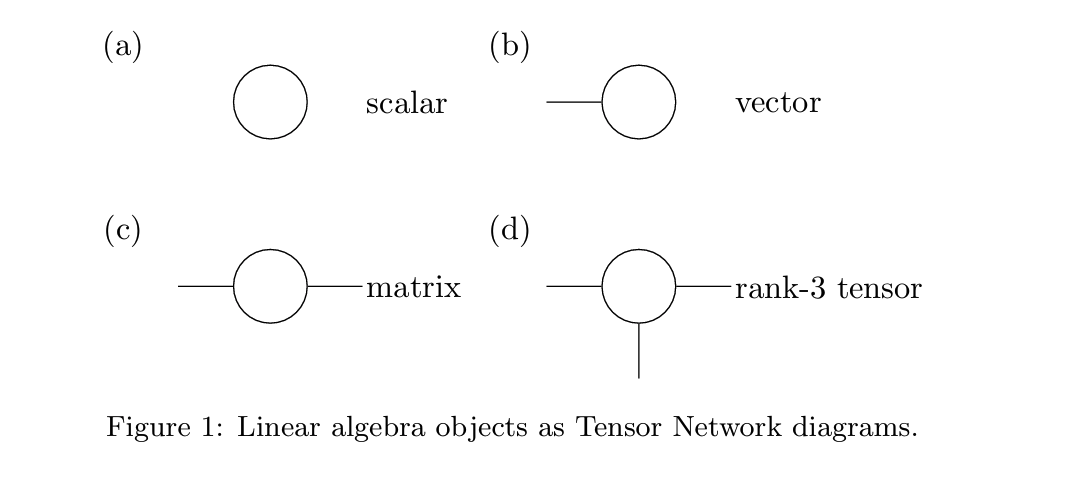
)

#### Tensor-train cross approximation (TT-cross)

Tensor-train cross approximation for multidimensional arrays is explained in detail in this [TT-cross paper](https://www.sciencedirect.com/science/article/pii/S0024379509003747?via%3Dihub). One does not need to know the technical details of the TT-cross algorithm for this challenge. By following that paper, as well as the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) we summarize the key intakes.

**The curse of dimensionality:** A tensor with $d$ indices (rank-$d$) has $d$ dimensions (is a $d$-dimensional array). Directly numerically handling arrays with many dimensions (called **multidimensional arrays**) is not feasible due to the so-called 'curse of dimensionality'. This term refers to the exponential increase in memory needed to store an array with $d$ indices, and the amount of operations needed to perform basic operations with such an array, as the dimensionality $d$ increases. 

**The aim of TT-cross algorithm:** This algorithm can accept **any** tensor. Its aim is to determine a suitable approximation of this tensor, approximating it to another (new) tensor with smaller number of parameters. Essentially, The TT-cross approximation algorithm is a technique used to approximate high-dimensional tensors in a low-dimensional format, known as Tensor Train (TT) format. The question then is, how do we accomplish this, and what tensor representation would be appropriate for the task?

**The essence of the TT-cross algorithm:** Consider the function $f$. The aim is to build a $d$-dimensional tensor in a Tensor Train format. For this, we sample whatever values we have within a chosen domain $\Omega \subset \mathbb{R}^{d}$ (but we cannot afford to sample the whole domain $\mathbb{R}^{d}$, since it grows exponentially with the number of dimensions $d$).

In more detail: Consider the tensor A, which is a d-dimensional array that represents the function $f$. It can be approximated as a TT-format as follows:

$$ A(i_{1}, i_{2}, \dots, i_{d}) \approx \sum_{r_{0}, r_{1}, \dots, r_{d}} G_{1}(r_{0}, i_{1}, r_{1})G_{2}(r_{1}, i_{2}, r_{2}) \cdots G_{d}(r_{d-1}, i_{d}, r_{d}) $$

Each tensor $G_{k}$ is a 3-dimensional tensor that is called a **TT core**. There are $d$ in number. $r_{k}$ are the ranks (also known as the **virtual dimensions**). Note that $r_{0}=r_{d}=1$.

Consider the cores $G_{k}$, reshaped to be 2-dimensional tensors (matrices). The algorithm starts with an initial guess for the tensor cores $G_{k}$, and a guess for the index sets of the rows and the columns (here $I_{k}$ and $J_{k}$ correspondingly). These index sets, at each process of the iteration, target submatrices with near-maximal volume (volume = the absolute value of the determinant of a matrix). Then one computes the series of the tensor cores $G_{k}$ over the selected entries. For this, one would need to identify the optimal low-rank approximation (with the use of singular value decomposition (SVD), for example). The final step is to assemble the tensor with the cores obtained in the previous step (which only have entries that correspond to $I_{k}$ and $J_{k}$). The process continues until a stopping criterion is met, usually a predefined tolerance for the approximation error. The result is an approximation of the original tensor, one that can be manipulated much more efficiently. You could read more in page 5 of the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

In this section we will closely follow the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) to use Tensor Networks and the **tensor-train cross approximation (TT-cross)** algorithm to overcome the probability loading problem. The steps you will need to follow will be described in detail below.


<div class="alert alert-block alert-success"> 

For this challenge we recommend using [jupyter notebook](https://jupyter.org/) (see [installation instructions](https://jupyter.org/install) on how to install). If you can not get this to work, another choice would be to use [Google colab](https://colab.google/).
                                                         
 </div>

#### STEP 1 -- Construct the Tensor Network

<div class="alert alert-block alert-success"> 
    
For this step you will need to install [tntorch](https://tntorch.readthedocs.io/en/latest/), [NumPy](https://numpy.org/) and [PyTorch](https://pytorch.org/).
 </div>

The aim of this step is to construct the *approximate* Tensor Network of the probability distribution defined in the **Problem Statement**. Before constructing the Tensor Network one would need to follow the **Quantization** process to map a continuous spectrum of values to a discrete one. After following this process, a continuous distribution $p(x)$ can be approximated by a discrete probability vector:
$$ \mathbf{p}=[p(x_{0}),p(x_{1}),\dots,p(x_{m})]$$
with $m$ the number of discretized points. Here we assume that $m=2^{d}-1$. We also require the vector $\mathbf{p}$ to be normalized.

Therefore, these m points, $\{ x_{i} \}_{i=0}^{m}$ can be encoded **on $d=log_{2}(m+1)$ qubits**.

The corresponding state then would be:
$$|\psi \rangle = \sum_{i=0}^{2^{d}-1} \sqrt{p(x_{i})} |(i)_{2} \rangle $$
with $(i)_{2}$ the index $i$ in base 2:

$$(i)_{2}=(i_{1},\dots,i_{d})=\sum_{k=1}^{d}i_{k}2^{d-k} $$

The vector $\mathbf{p}$ of size $2^{d}$ can be written as a tensor $A \in \mathbb{R}^{2\times \cdots \times 2} $, by writting each $p(x_{i})$ in a Tensor Network format, as shown by the figure:


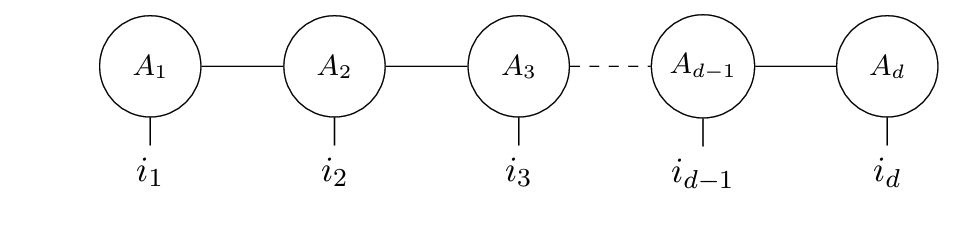

Note that the *arrangement* of the tensors is particularly important when dealing with more than one dimensions (like in our case, where we have a multivariate distribution). This is because, for the 1D case, the only thing that matters is how many qubits one uses (that defines the granularity). However, with higher dimensions it is not trivial to see how to arrange the tensors to create a (one-dimensional) Tensor Train.

**TASK:** 
- With the use of  [tntorch](https://tntorch.readthedocs.io/en/latest/) create a Tensor Network of the distribution defined in the **Problem Statement**. You can use [TT-cross](https://tntorch.readthedocs.io/en/latest/tutorials/cross.html?highlight=cross), [TT-cross 2](https://tntorch.readthedocs.io/en/latest/api.html#module-cross).
- Use **bond dimension = 8** and **number of qubits/dimension = 10**. Consider the **univariate case** ($n_{\text{dimensions}}=1$) as well as the cases $n_{\text{dimensions}}=2$ and $n_{\text{dimensions}}=4$.

<div class="alert alert-block alert-info">  
    
Note that you can decompress the tensor into a NumPy ndarray (which is a d-dimensional tensor) after reading the [tensor module documentation of tntorch](https://tntorch.readthedocs.io/en/latest/api.html?highlight=tensor%20object#module-tensor). You will be needing this for the exercises below.

 </div>

<div class="alert alert-block alert-danger">
    
<b>IMPORTANT ADDITIONAL EXERCISE:</b> 
*The recommendation is to finish the rest of the steps of Section 2, before coming back to do this Important Exercise.*
 As discussed above, the arrangement of the tensors is particularly important when dealing with multivariate distributions. In the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) there are three representations presented: Sequential, Mirroring and Interleaving. Choose one (or more!) of them, justify your choice and create the Tensor Network.
</div>

**Imports:**

In [4]:
# Tools
import re
import numpy as np
import itertools
from scipy.stats import multivariate_normal

# TN
import torch
import tntorch as tn

# Quantum
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import circuit_drawer
from qiskit_aer import QasmSimulator

# Plotting
import matplotlib.pyplot as plt

**Answer:**

In [10]:
gaussian_parameters = {
    1: (0.1, 0.2),
    2: (np.array([0.10, 0.10]), np.array([[0.896, 0.156], [0.156, 0.203]])),
    4: (np.array([0.10, 0.10, 0.10, 0.10]), np.array([
        [0.57960932, 0.53557326, 0.72277726, 0.45446549],
        [0.53557326, 1.78714288, 1.27653285, 1.40874688],
        [0.72277726, 1.27653285, 1.61989663, 1.00916545],
        [0.45446549, 1.40874688, 1.00916545, 1.12400343]]))
}

In [11]:
import torch

# Example tensor t of shape (n, 4*b)
n, b = 3, 3
t = torch.arange(n * 5 * b).reshape(n, 5 * b)

# Example permutation string
perm_str = 'perm(2,0,3,1,4)'

# Extract integers from the permutation string
indices = list(map(int, perm_str[perm_str.find('(')+1 : perm_str.find(')')].split(',')))

# Rearrange the blocks
blocks = [t[:, i*b:(i+1)*b] for i in indices]
t = torch.cat(blocks, dim=1)

print(t)

tensor([[ 6,  7,  8,  0,  1,  2,  9, 10, 11,  3,  4,  5, 12, 13, 14],
        [21, 22, 23, 15, 16, 17, 24, 25, 26, 18, 19, 20, 27, 28, 29],
        [36, 37, 38, 30, 31, 32, 39, 40, 41, 33, 34, 35, 42, 43, 44]])


In [12]:
def create_tensor_network(
        bond_dim, 
        n_qubits_per_dim,
        mu, 
        cov_matrix, 
        grids, 
        encoding='sequential',
        eps=1e-6,
        verbose=False
    ):
    """
    Create a multivariate Gaussian Tensor Network using TT-cross approximation.

    Parameters:
    - bond_dim: int, TT bond dimension
    - n_qubits_per_dim: int, Number of qubits per dimension
    - mu: np.ndarray, Mean vector of shape (d,)
    - cov_matrix: np.ndarray, Covariance matrix of shape (d, d)
    - grids: list of np.ndarray, list of 1D grids for each dimension (len(grids) == d)
    - encoding: str, one of 'sequential', 'mirroring', or 'interleaved'

    Returns:
    - qtt: tntorch.tensor.Tensor, Tensor Network in TT format
    """

    d = len(mu)  # number of dimensions
    b = n_qubits_per_dim
    total_qubits = d * b

    # Each index is binary (0 or 1) → domain = list of torch.tensor([0, 1])
    domain = [torch.tensor([0.0, 1.0])] * total_qubits

    # Powers of 2 for binary-to-decimal conversion
    powers = 2 ** torch.arange(b - 1, -1, -1)

    def reorder_bits(bits):
        if encoding == 'sequential':
            return bits  # already in correct order

        elif encoding == 'mirroring':
            if d != 2:
                raise ValueError("Mirroring encoding is only supported for d=2.")
            bits = bits.view(-1, d, b)
            bits[:, 0] = bits[:, 0, torch.arange(b - 1, -1, -1)]
            return bits.view(bits.shape[0], -1)
        
        elif encoding == 'interleaved':
            bits = bits.view(-1, b, d).transpose(1, 2).contiguous()
            return bits.view(bits.shape[0], -1)
        
        # encoding of the form 'perm(a,b,c,...)' 
        elif 'perm' in encoding: 
            # Extract integers from the permutation string
            indices = list(map(int, re.findall(r'\d+', encoding))) 

            # Rearrange the blocks
            blocks = [bits[:, i*b:(i+1)*b] for i in indices]
            bits = torch.cat(blocks, dim=1)
            return bits
            
        else:
            raise ValueError(f"Unknown encoding type: {encoding}")

    # Precompute full grid of all bitstrings to normalize the PDF values
    all_bitstrings = list(itertools.product([0, 1], repeat=total_qubits))
    all_coords = []
    mvn = multivariate_normal(mean=mu, cov=cov_matrix)

    for bits in all_bitstrings:
        bits_tensor = torch.tensor(bits).view(1, -1).int()
        bits_tensor = reorder_bits(bits_tensor)
        coords = []
        for i in range(d):
            bits_i = bits_tensor[:, i * b:(i + 1) * b]
            idx = torch.sum(bits_i * powers, dim=1)
            coord = grids[i][idx.item()]
            coords.append(coord)
        all_coords.append(coords)

    points = np.array(all_coords)  # shape: (2^total_qubits, d)
    normalization = np.sum(mvn.pdf(points))

    def gaussian_pdf(*bits):
        bits = torch.stack(bits, dim=1).int()  # (P, d*b)
        bits = reorder_bits(bits)

        # Decode each variable
        coords = []
        for i in range(d):
            bits_i = bits[:, i * b:(i + 1) * b]
            idx = torch.sum(bits_i * powers, dim=1)
            coord = torch.tensor(grids[i])[idx]  # shape: (P,)
            coords.append(coord)

        # Stack to shape (P, d)
        points = torch.stack(coords, dim=1)

        # Evaluate and normalize multivariate normal at each point
        mvn_vals = mvn.pdf(points.numpy()) / normalization
        pdf_vals = torch.tensor(mvn_vals, dtype=torch.float32)

        return pdf_vals
    
    # Build TT using TT-cross
    qtt, info = tn.cross(
        gaussian_pdf,
        domain=domain,
        ranks_tt=bond_dim,
        max_iter=100,
        function_arg='vectors',
        verbose=verbose,
        eps=eps,
        return_info=True,
        suppress_warnings=True
    )

    return qtt, info

##### 1-D example: ``bond_dim = 8, n_qubits=10``

In [13]:
mu, covm = gaussian_parameters[1]
n_qubits = 10
bond_dim = 8
grid = np.linspace(-1, 1, 2**n_qubits)
qtt1, info = create_tensor_network(
    bond_dim=bond_dim, 
    n_qubits_per_dim=n_qubits, 
    mu=[mu], 
    cov_matrix=covm, 
    grids=[grid],
    verbose=True
)
qtt1

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0   | eps: 6.570e-07 | time:   0.0157 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 0.001562s (8.682e+05 evals/s)



10D TT tensor:

  2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   8   8   8   8   4   2   1

##### 2-D example: ``bond_dim = 8, n_qubits=10``

In [14]:
d = 2
mu, covm = gaussian_parameters[d]
n_qubits = 5
bond_dim = 8
grid = np.linspace(-1, 1, 2**n_qubits)
qtt2, info = create_tensor_network(
    bond_dim=bond_dim, 
    n_qubits_per_dim=n_qubits, 
    mu=mu, 
    cov_matrix=covm, 
    grids=[grid]*d,
    encoding='mirroring',
    verbose=True
)
qtt2

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0   | eps: 5.483e-07 | time:   0.0157 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 0.00234s (5.796e+05 evals/s)



10D TT tensor:

  2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   8   8   8   8   4   2   1

##### 4-D example: ``bond_dim = 8 or 64, n_qubits=12``

This example shows that ``bond_dim=8`` may sometimes be insufficient for good approximation, as it does not capture the correlations between indices that are far apart

In [15]:
d = 4
mu, covm = gaussian_parameters[d]
n_qubits = 3
bond_dim = 8
grid = np.linspace(-1, 1, 2**n_qubits)
qtt4, info = create_tensor_network(
    bond_dim=bond_dim, 
    n_qubits_per_dim=n_qubits, 
    mu=mu, 
    cov_matrix=covm, 
    grids=[grid]*d,
    encoding='sequential',
    verbose=True
)
qtt4

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 12D domain containing 4096 grid points:
iter: 0   | eps: 7.046e-01 | time:   0.0179 | largest rank:   8
iter: 1   | eps: 7.013e-01 | time:   0.0347 | largest rank:   8
iter: 2   | eps: 7.017e-01 | time:   0.0514 | largest rank:   8
iter: 3   | eps: 6.966e-01 | time:   0.0676 | largest rank:   8
iter: 4   | eps: 7.008e-01 | time:   0.0843 | largest rank:   8
iter: 5   | eps: 6.974e-01 | time:   0.1005 | largest rank:   8
iter: 6   | eps: 6.400e-01 | time:   0.1164 | largest rank:   8
iter: 7   | eps: 5.805e-01 | time:   0.1319 | largest rank:   8
iter: 8   | eps: 5.807e-01 | time:   0.1477 | largest rank:   8
iter: 9   | eps: 5.807e-01 | time:   0.1638 | largest rank:   8
iter: 10  | eps: 5.807e-01 | time:   0.1795 | largest rank: 

12D TT tensor:

  2   2   2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   8   8   8   8   8   8   4   2   1

In [16]:
d = 4
mu, covm = gaussian_parameters[d]
n_qubits = 3
bond_dim = 64
grid = np.linspace(-1, 1, 2**n_qubits)
qtt4, info = create_tensor_network(
    bond_dim=bond_dim, 
    n_qubits_per_dim=n_qubits, 
    mu=mu, 
    cov_matrix=covm, 
    grids=[grid]*d,
    verbose=True
)
qtt4

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 12D domain containing 4096 grid points:
iter: 0   | eps: 5.816e-07 | time:   0.0270 | largest rank:  64 <- converged: eps < 1e-06
Did 21836 function evaluations, which took 0.004758s (4.589e+06 evals/s)



12D TT tensor:

  2   2   2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   16  32  64  32  16  8   4   2   1

#### STEP 2 -- Construct the circuit from the Tensor Network

The aim of this step is to decompose the tensor $A(i_{1},\dots,i_{d})$, written in the following tensor network form:
$$A(i_{1},\dots,i_{d})=\sum_{r_{0},r_{1},\dots,r_{d}}G_{1}(r_{0},i_{1},r_{1})G_{2}(r_{1},i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$


in order to construct a circuit; a set of unitary operators $\{W_{i}\}$ that represent quantum gates. Applying these gates into the initial state, we get the target state:

$$|\psi \rangle = W_{1}W_{2}\cdots W_{d-1}W_{d}|0\rangle^{\otimes d} $$

The equivalence looks like this:

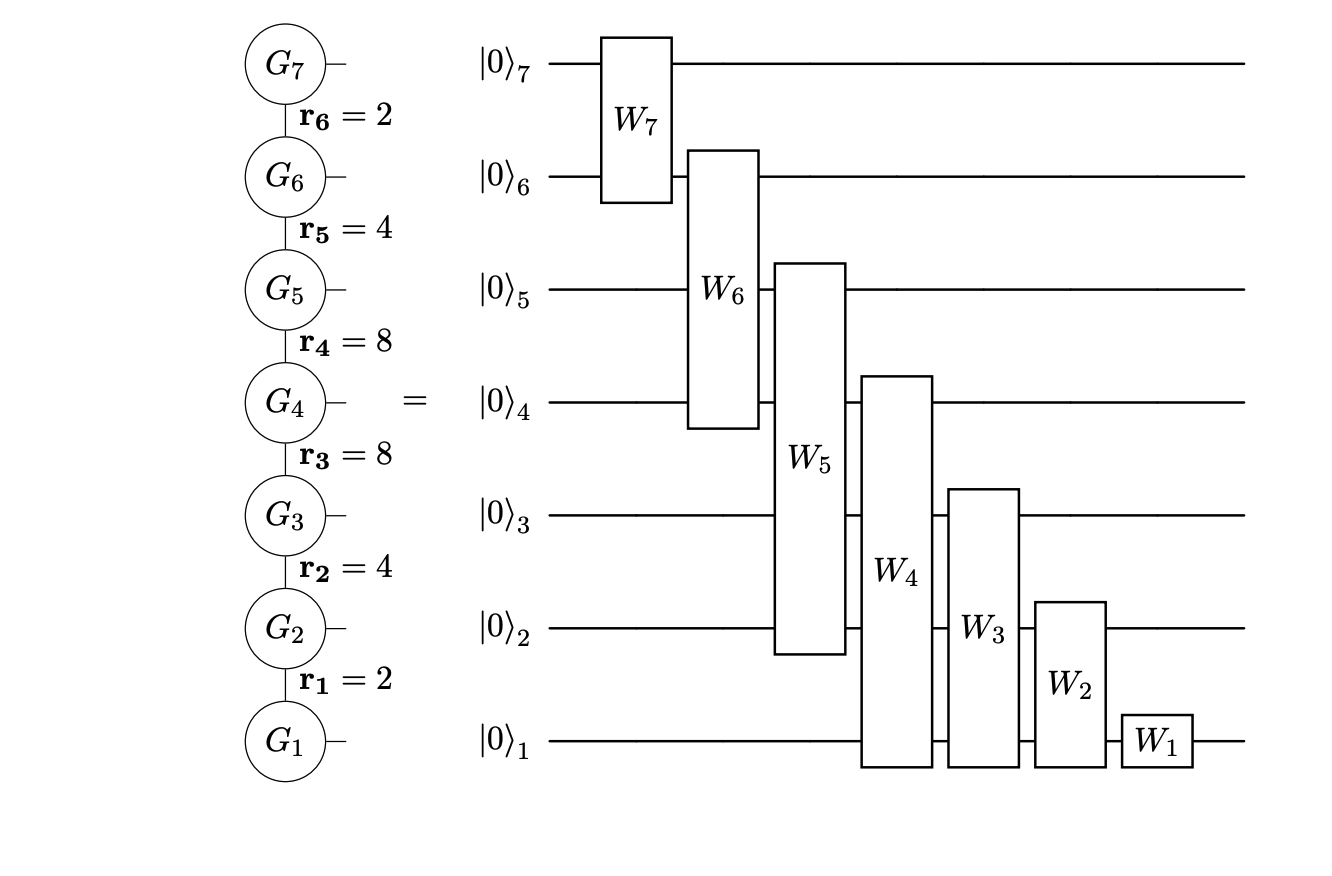

The algorithm you need to develop is shown in the picture below:

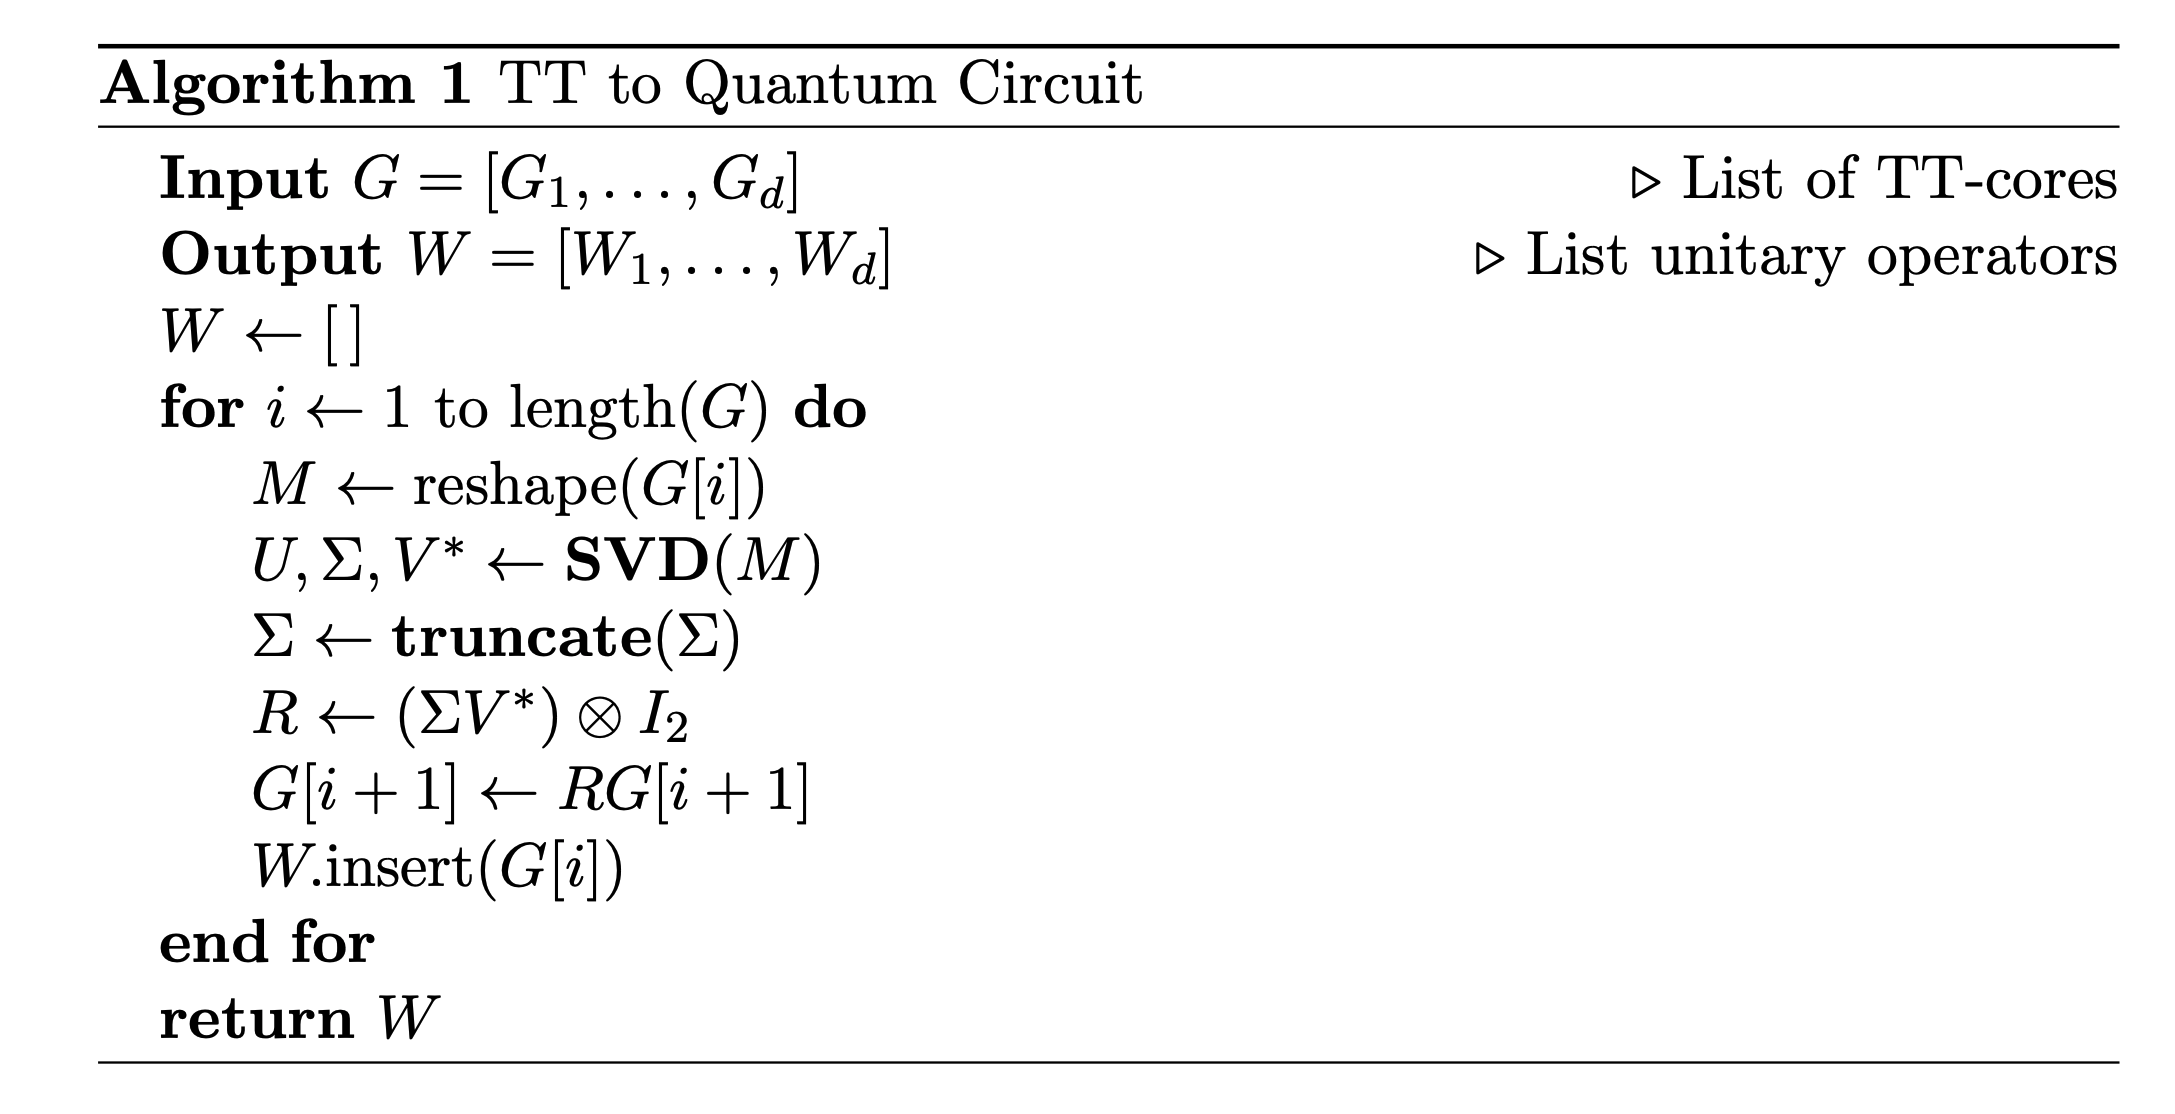


One would need to read the instructions in pages 8-10 of paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) to understand how to implement this algorithm. For completion, we write the steps below.
    

The aim is to find the unitary opeerators of the circuit above (operators $W_{k}$). We will do this sequentially, handling one tensor $G_{k}$ at a time.

$\mathbf{k=1}$:
- First reshape the tensor $M_{1}(i_{1},r_{1})=G_{1}(r_{0}=0, i_{1}, r_{1})$ into a $\mathbb{C}^{2 \times n_{1}}$ matrix. Note here that I already substitute the value of $r_{0}=0$.
- We factor the matrix $M_{1}$ with the use of the SVD theorem as following: $M_{1}=U_{1}\Sigma_{1} V^{*}_{1}$, where $U_{1} \in \mathbb{C}^{2 \times 2}$ and $V^{*}_{1}\in \mathbb{C}^{n_{1}\times n_{1}}$ are unitary matrices. $\Sigma_{1} \in \mathbb{C}^{2 \times n_{1}}$ is a diagonal matrix that contains the singular values of $M_{1}$. 
- We substitute the above in $A(i_{1},\dots,i_{d})$:
  $$\sum_{j=0,1} U_{1}(i_{1},j)\bigg[\sum_{r_{2},\dots,r_{d}} \tilde{G}_{2}(j,i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d}) \bigg]$$
  with $\tilde{G}_{2}(j,i_{2},r_{2})$ **containing the rest matrices that come from the SVD**: $\tilde{G}_{2}(j,i_{2},r_{2})=\sum_{r_{1}}(\Sigma_{1}V^{*}_{1})(j,r_{1})G_{2}(r_{1},i_{2},r_{2})$. For now on we drop the tilde and write $\tilde{G}_{2}=G_{2}$.
- We set $W_{1}$ to be **the unitary operator $U_{1}$ that comes from the SVD. This is our first unitary operator of the quantum circuit!** $W_{1}$ is acting only on the first qubit. It can be seen as the action of the unitary operation on $\mathbb{C}^{2}\otimes \mathbb{C}^{2^{d-1}}:$
  $$|0\rangle \otimes |\upsilon \rangle \rightarrow U_{1}(0,0)|0\rangle \otimes |\upsilon \rangle + U_{1}(1,0)|1\rangle \otimes |\upsilon \rangle
  $$
  $$|1\rangle \otimes |\upsilon \rangle \rightarrow U_{1}(0,1)|0\rangle \otimes |\upsilon \rangle + U_{1}(1,1)|1\rangle \otimes |\upsilon \rangle $$

$\mathbf{k=2:}$
- Now we turn our attention to the tensor in the brackets, which we name $A^{(2)}$:
  $$A^{(2)}(j,i_{2},\dots,i_{d})=\sum_{r_{2},\dots,r_{d}}G_{2}(j,i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$
- The index $j$ can be reduced by **truncating** the singular values of the matrix $\Sigma$: the rows of $\Sigma(j,:)$ are null if $j \ge \min(2,n_{1})$. We use the symbol $a\wedge b$ for $\min(a,b)$ below. **Do not reduce the singular values here.**
- Assume that the bond dimensions are $n_{2}=2^{l_{2}}$.

$\mathbf{k\ge 2}:$
- We iterate by defining $A^{(k)}:$
$$A^{(k)}(j,i_{k},\dots,i_{d})=\sum_{r_{k},\dots,r_{d}}G_{k}(j,i_{k},r_{k})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$
with $j=0,\dots,2^{(k-1)\wedge l_{k-1}}-1$.
- Reshape the tensor $G_{k}$ into a matrix $M_{k}\in \mathbb{C}^{m_{k}\times n_{k}}$ with $m_{k}=2(2^{(k-1)\wedge l_{k-1}})=2^{k\wedge (1+l_{k-1})}$ and $n_{k}$ the bond dimension.
- As before, we use SVD to decompose $M_{k}=U_{k}\Sigma_{k}V^{*}_{k}$.
- $U_{k}$ is the $k$th unitary operator in the circuit, which we name $W_{k}$. Note that since the series of $M_{k}$ are $m_{k}=2^{k\wedge (1+l_{k-1})}$ (which is the same as the series of $W_{k}$), the unitary operator $W_{k}$ acts on the qubits $k, \dots, k-k \wedge l_{k-1}$.
- $\Sigma_{k}V^{*}_{k}$ is then passed to $G_{k+1}$ and the process continues..

<div class="alert alert-block alert-info">  
    
- The core tensors $\{G_{i}\}$ would need to be reshaped before the singular value decomposition (SVD). One could do that with [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

- If you want to permute the indices of tensors you can use [numpy.transpose](https://numpy.org/doc/2.2/reference/generated/numpy.transpose.html).

- One could read more on tensor networks here: [The density-matrix renormalization group in the age of matrix product states
](https://arxiv.org/abs/1008.3477). This could be needed specifically if you want to understand SVD. SVD is mentioned in page 15.
    
 </div>

**Answer:**

The code below uses the 2-D example from ***Step 1*** to create a circuit, and computes ``fidelity``=$|\langle\psi_{tg}|\psi_{tt}\rangle|$, where $|\psi_{tg}\rangle$ is the state after the application of the circuit to the state $|0\rangle$, and $|\psi_{tt}\rangle$ is the vectorization of the TT. The resulting ``fidelity=1``, which confirms correctness of the generated gates. In addition, we compute ``max error`` to compare the maximum absolute difference between the actual values of the vectors.

In [17]:
def tt_to_qc_gates(G, normalize=True, tol=1e-12):
    """
    Transform a list of Tensor-Train (TT) cores `G` into a list of unitary matrices W_k (torch.Tensor).

    Args:
        G (list of torch.Tensor): TT cores of shapes [(r_{k-1}, 2, r_k)], k=1..d.
        normalize (bool): if True, normalize the final gate by its only singular value.
        tol (float): singular-value truncation tolerance.

    Returns:
        gates (list of torch.Tensor): list of W_k of shape (m_k, m_k).
    """
    d = len(G)
    cores = [g.clone().detach() for g in G]
    gates = []

    for k in range(d):
        core = cores[k]
        r_prev, phys_dim, r_next = core.shape
        m_k = phys_dim * r_prev  # number of rows
        # make sure m_k is the power of 2
        m_k = 1 << (m_k - 1).bit_length()
        # if m_k == 14:
        #     import pdb; pdb.set_trace()
        n_k = r_next             # number of cols

        # reshape to M_k of shape (m_k, n_k)
        M = core.reshape(m_k, n_k)

        # SVD
        U, S, Vh = torch.linalg.svd(M, full_matrices=True)
        S = S.to(torch.complex128)

        # truncate
        mask = (S.abs() > tol)
        rank = 1 << (int(mask.sum().item()) - 1).bit_length()
        U = U[:, :rank]
        S = S[:rank]
        Vh = Vh[:rank, :]

        # build full unitary W of shape (m_k, m_k)
        W = torch.zeros((m_k, m_k), dtype=U.dtype, device=U.device)
        # print(W.shape)
        W[:, :rank] = U
        if rank < m_k or (normalize and k == d - 1):
            # complete ONB
            rand_mat = torch.randn((m_k, m_k - rank), dtype=U.dtype, device=U.device)
            comp = rand_mat - U @ (U.conj().T @ rand_mat)
            Q, _ = torch.linalg.qr(comp)
            # note that this step also accounts for normalization at the end
            W[:, rank:] = Q[:, :m_k - rank]
            
        gates.append(W)

        # S_diag = torch.zeros((S.shape[0], S.shape[0]), dtype=torch.complex128)
        # S = torch.diag(S), dtype=torch.complex128)

        # update next core by contracting (S @ Vh)
        if k + 1 < d:
            R = torch.diag(S) @ Vh  # shape (rank, n_k)
            next_core = cores[k + 1]
            # contract R with next_core over r_k index
            # new_core[j, i, r] = sum_{r_k} R[j,r_k] * next_core[r_k,i,r]
            cores[k + 1] = torch.einsum('jr,rik->jik', R, next_core)

    return gates


def tt_to_statevector_from_cores(G):
    """
    Contract TT cores into full statevector of shape (2**d,).
    """
    d = len(G)
    # start with first core
    psi = G[0][0, :, :]  # shape (2, r1)
    for k in range(1, d):
        psi = torch.einsum("ij,jkl->ikl", psi, G[k])
        psi = psi.reshape(-1, G[k].shape[-1])
        # psi = torch.tensordot(psi, G[k], dims=([-1], [0]))
        # psi shape recursively: (2,...,2, r_{k+1})
    psi = psi.squeeze(-1)  # drop last bond
    psi = psi.reshape(-1)
    psi = psi / torch.norm(psi)
    return psi.cpu().numpy()


def apply_gates_to_zero_state(gates, d):
    """
    Apply list of unitary matrices `gates` to the zero state |0>^d by tensor contractions.
    Gates are applied in reverse order: first W_d on last qubits, then W_{d-1}, ..., W_1.

    Returns:
        psi (np.ndarray): final statevector of shape (2**d,)
    """
    # initial statevector: [1,0,...,0]
    psi = torch.zeros((2**d,), dtype=gates[-1].dtype)
    psi[0] = 1.0

    for i, W in enumerate(reversed(gates)):
        m_k = W.shape[0]
        # number of qubits this gate acts on
        nq = int(round(torch.log2(torch.tensor(m_k, dtype=torch.float64)).item()))
        # global_gate
        global_gate = torch.kron(torch.kron(torch.eye(2**(d-i-nq)), W), torch.eye(2**(i)))
        psi = global_gate @ psi

    # flatten and normalize
    psi_final = psi#psi_tensor.reshape(-1)
    psi_final = psi_final / torch.norm(psi_final)
    return psi_final.cpu().numpy()


def verify_tt_to_qc(G, tol=1e-12, atol=1e-6):
    """
    Verify TT->QC mapping by comparing direct TT contraction vs applying gates.

    Returns:
        fidelity: |<psi_tt|psi_qc>|^2
        max_err: max |psi_tt - psi_qc_aligned|
    """
    # get reference state
    psi_tt = tt_to_statevector_from_cores(G)
    # get gates
    gates = tt_to_qc_gates(G, normalize=True, tol=tol)
    # apply gates
    psi_qc = apply_gates_to_zero_state(gates, len(G))
    # align global phase
    ov = np.vdot(psi_tt, psi_qc)
    phase = ov / abs(ov)
    psi_qc_aligned = psi_qc * np.conj(phase)
    fidelity = abs(ov)**2
    max_err = np.max(np.abs(psi_tt - psi_qc_aligned))
    return fidelity, max_err

# # Example usage
def _example():
    G = [elem.to(torch.complex128) for elem in qtt2.cores]
    fid, err = verify_tt_to_qc(G)
    print(f"Fidelity={fid:.6f}, max error={err:.3e}")

if __name__ == "__main__":
    _example()


Fidelity=1.000000, max error=2.567e-16


#### STEP 3 -- Reduce the depth of the circuit

This step is for your interest only - there is no need to implement this.

One can merge the tensors ${W_{i}}$ by summing over their virtual indices in order to create a quantum circuit with less depth. In the case of four qubits this is shown below: 
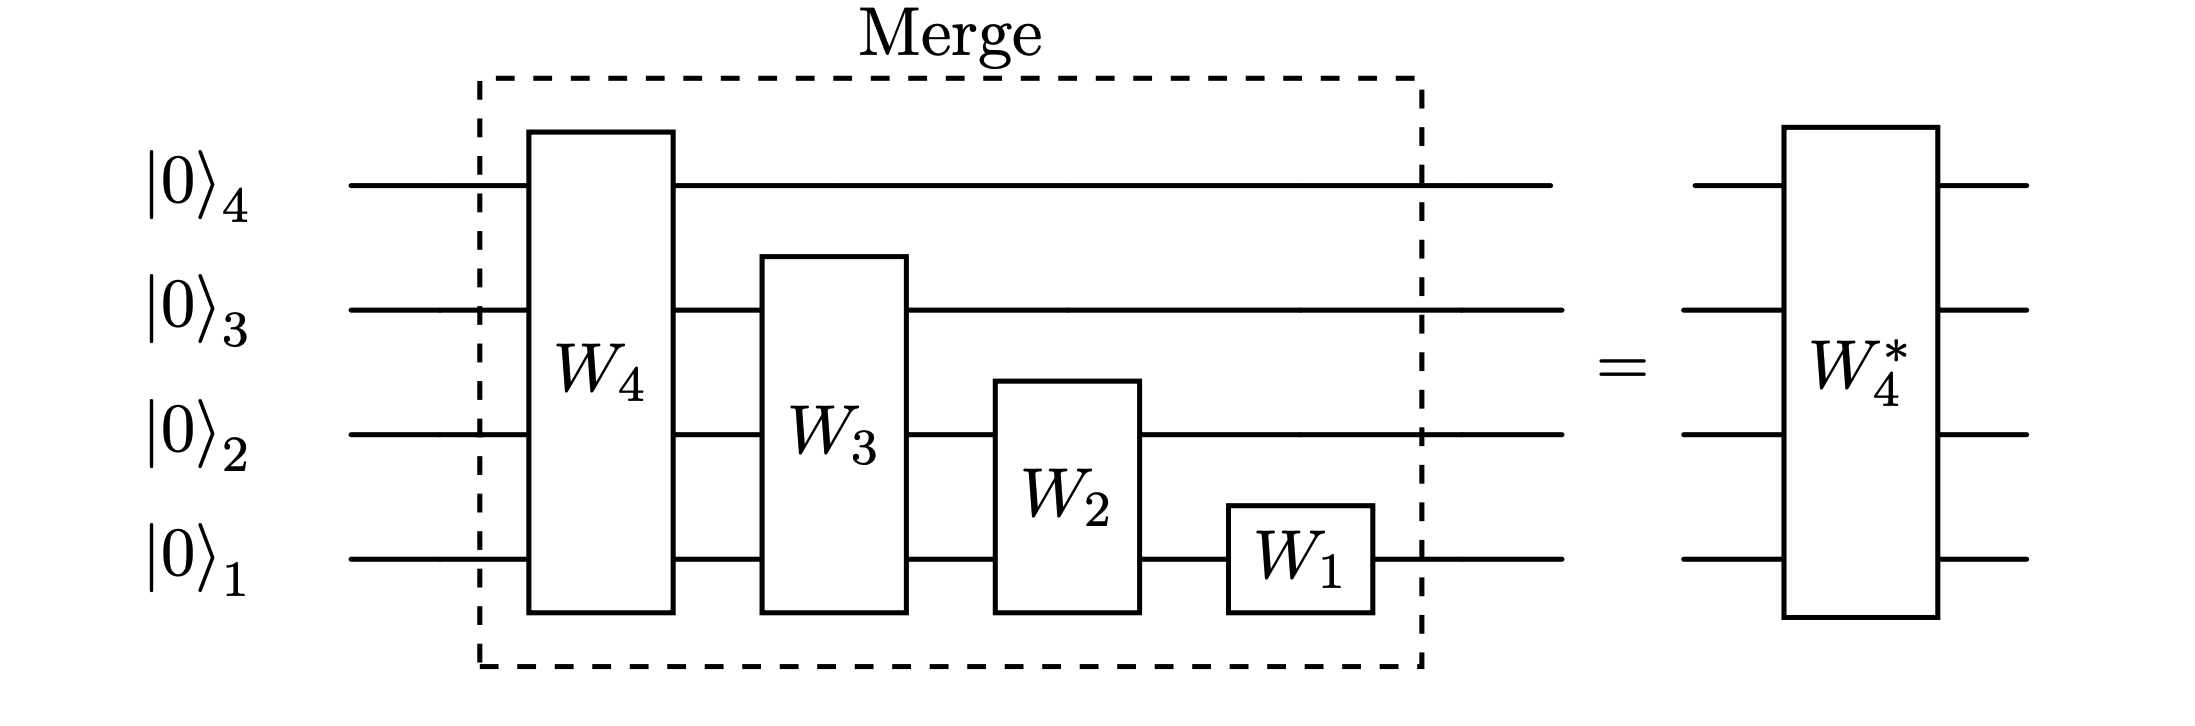



Note that by doing this one improves the efficiency, by reducing the likelihood of decoherence when using quantum hardware. Since we will not be using quantum hardware, there is **no need to implement this step**.

#### STEP 4 -- Implementation in Qiskit

<div class="alert alert-block alert-success"> 
    
For this step you will need to install Qiskit version 2.0.
 </div>

After applying **Algorithm 1**, use the [Qiskit UnitaryGate method](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UnitaryGate) to implement the circuit. 

Use the simulator [QasmSimulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.QasmSimulator.html) to verify that the above circuit represents the probability distribution in question.

**Answer:**

In [18]:
class UnitaryCircuitRunner:
    """
    Constructs and simulates a quantum circuit by applying a sequence of arbitrary-dimension
    unitary matrices to a chain of qubits. Each unitary acts starting from its index and spans
    the number of qubits required by its size.
    """

    def __init__(self, unitary_list):
        """
        Initialize the runner with a list of unitary matrices.

        Args:
            unitary_list (List[np.ndarray or torch.Tensor]): List of unitary matrices (must be powers of 2 in size).
        """
        self.unitary_list = unitary_list
        self.n_qubits = self._calculate_required_qubits()
        self.circuit = QuantumCircuit(self.n_qubits)

    def _calculate_required_qubits(self):
        """
        Determine the total number of qubits required to apply all unitary gates.

        Returns:
            int: Total number of qubits needed for the circuit.
        """
        max_required = 0
        for idx, u in enumerate(self.unitary_list):
            if isinstance(u, torch.Tensor):
                u = u.cpu().numpy()
            num_qubits = int(np.log2(u.shape[0]))
            end = idx + num_qubits
            max_required = max(max_required, end)
        return max_required

    def build_circuit(self):
        """
        Build the quantum circuit by appending each UnitaryGate to the correct set of qubits.
        """
        for idx, u in enumerate(self.unitary_list):
            if isinstance(u, torch.Tensor):
                u = u.cpu().numpy()
            num_qubits = int(np.log2(u.shape[0]))
            gate = UnitaryGate(u, label=f"U{idx+1}")
            qubits = list(range(idx, idx + num_qubits))
            self.circuit.append(gate, qubits)

    def run(self, shots=1024):
        """
        Run the quantum circuit on QasmSimulator and return the measurement results.

        Args:
            shots (int): Number of shots to simulate.

        Returns:
            dict: Measurement outcome counts.
        """
        simulator = QasmSimulator()
        if not self.circuit.get_instructions('measure'):
            self.circuit.measure_all()
        transpiled = transpile(self.circuit, simulator)
        result = simulator.run(transpiled, shots=shots).result()
        counts = result.get_counts()
        # print("Measurement Results:", counts)
        return counts

    def plot_circuit(self):
        """
        Draw the quantum circuit.

        Returns:
            matplotlib.figure.Figure: The figure of the circuit diagram.
        """
        return circuit_drawer(self.circuit, output='mpl')

    def get_num_qubits(self):
        """
        Returns the number of qubits in the circuit.
        """
        return self.n_qubits

    def get_circuit_depth(self):
        """
        Returns the depth of the circuit.
        """
        # Ensure the circuit is built before checking depth
        if not self.circuit.data:
            self.build_circuit()
        return self.circuit.depth()

    def plot_approximated_pdf_1d(self, counts, shots, n_bins=50, x_range=None, title="Approximated PDF from Quantum Circuit", plot=False):
        """
        Plot an approximated PDF (histogram) from measurement counts,
        rescaling basis |00...0> to -1 and |11...1> to +1.
        Also returns a dict mapping bitstrings to their probabilities.
        """
        n = len(next(iter(counts)))  # Number of qubits (bitstring length)
        max_val = 2**n - 1

        # Map bitstrings to rescaled values in [-1, +1]
        values = [int(k, 2) for k in counts.keys()]
        rescaled_values = [2 * v / max_val - 1 for v in values]
        # print(counts)
        probs = [v / shots for v in counts.values()]
        # print("MAX PROB =", max(probs))
        # samples = []
        # for val, p in zip(rescaled_values, probs):
        #     samples.extend([val] * int(p * shots))
        # Build proper sample array using random choice (avoids quantization errors)
        samples = np.random.choice(rescaled_values, size=shots, p=probs)


        # Calculate mean and standard deviation (in rescaled space)
        mean = gaussian_parameters[1][0]#np.mean(samples)
        std = np.sqrt(gaussian_parameters[1][1])#np.std(samples)
        # print(f"Rescaled Mean: {mean:.4f}")
        # print(f"Rescaled Standard Deviation: {std:.4f}")

        if plot:
            plt.figure(figsize=(8, 4))
            # Plot histogram (PDF)
            plt.bar(rescaled_values, probs)
            counts_hist, bins, _ = plt.hist(samples, bins=n_bins, range=x_range, density=True,
                                            alpha=0.75, color='skyblue', edgecolor='black', label='Histogram')

            # Plot Gaussian curve
            # bin_centers = 0.5 * (bins[1:] + bins[:-1])
            # gaussian = norm.pdf(bin_centers, mean, std)
            # plt.plot(bin_centers, gaussian, 'r-', lw=2, label=f'$N({np.round(mean, 2)}, {np.round(gaussian_parameters[1][1], 2)})$')

            plt.xlabel("Rescaled Value (|00...0⟩ → -1, |11...1⟩ → +1)")
            plt.ylabel("Estimated PDF")
            plt.title(title)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Return dict of bitstring: probability
        bitstring_probs = {k: v / shots for k, v in counts.items()}
        return bitstring_probs

    def plot_approximated_pdf_2d(self, counts, shots, encoding='sequential', title="Empirical Heatmap with Mean Marker (Rescaled Axes)"):
        n = len(next(iter(counts)))
        assert n % 2 == 0, "Number of qubits must be even"
        half_n = n // 2
        size = 2**half_n

        mean = gaussian_parameters[2][0]
        cov = gaussian_parameters[2][1]

        # Empirical probability grid
        prob_grid = np.zeros((size, size))
        for bitstring, count in counts.items():
            x_bits = bitstring[:half_n]
            y_bits = bitstring[half_n:]
            if encoding == 'mirroring':
                # print("before:", x_bits, int(x_bits, 2))
                x_bits = x_bits[::-1]
                # print("after:", x_bits, int(x_bits, 2))
            elif encoding == 'interleaved':
                x_bits = bitstring[::2]
                y_bits = bitstring[1::2]
            x = int(x_bits, 2)
            y = int(y_bits, 2)
            prob_grid[y, x] += count / shots

        # Create rescaled axes from -1 to 1
        rescaled_vals = np.linspace(-1, 1, size)
        extent = [-1, 1, -1, 1] # [xmin, xmax, ymin, ymax]

        # Rescale the mean coordinates
        mean_x, mean_y = mean

        # Plot
        plt.figure(figsize=(6, 5))
        im = plt.imshow(prob_grid, origin='lower', cmap='viridis', extent=extent)
        plt.colorbar(im, label="Probability")
        plt.title(title)
        plt.xlabel("Rescaled x")
        plt.ylabel("Rescaled y")

        plt.scatter([mean_x], [mean_y], facecolors='none', s=80, edgecolors='red', linewidths=1.5, label='Mean')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        return {k: v / shots for k, v in counts.items()}


##### 1-D circuit and histogram

Number of qubits: 10
Circuit depth: 11


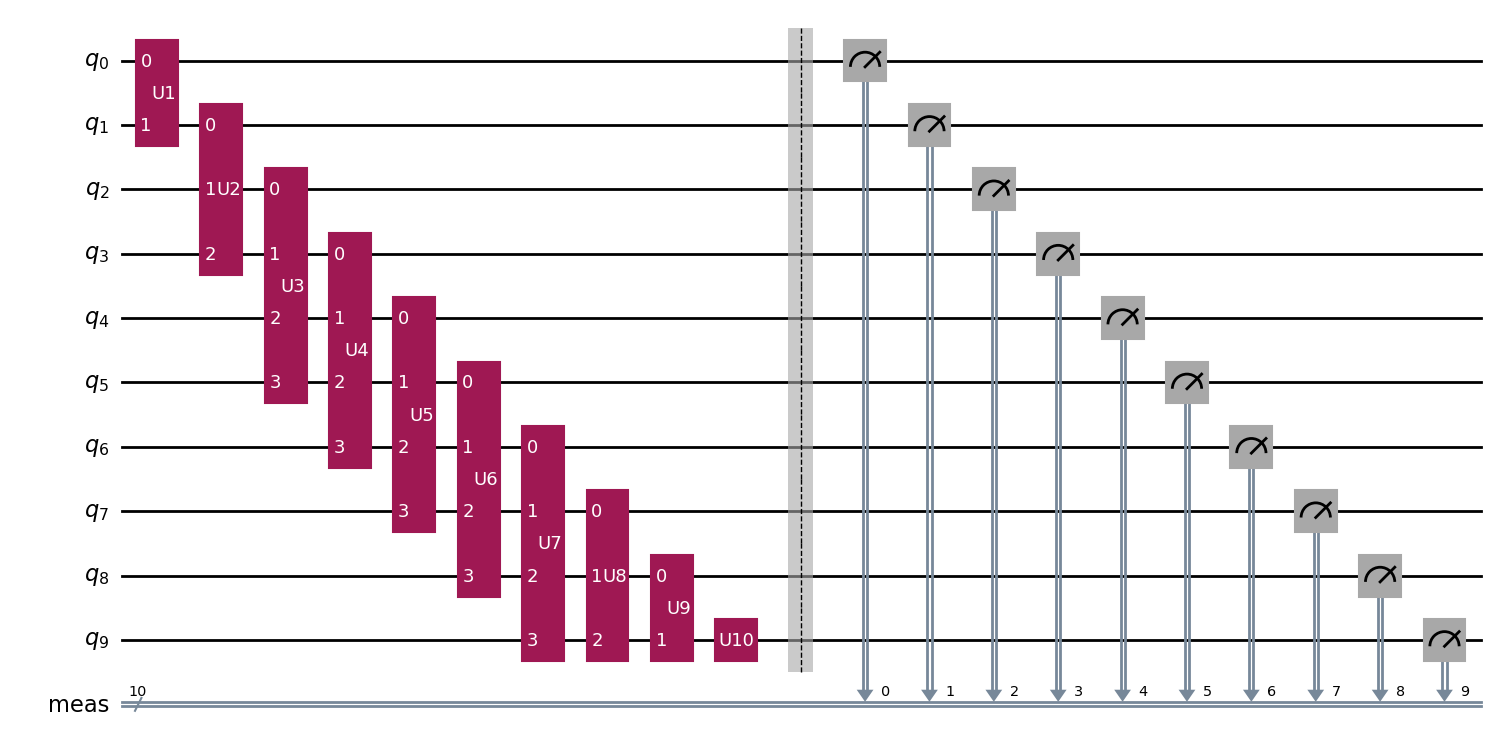

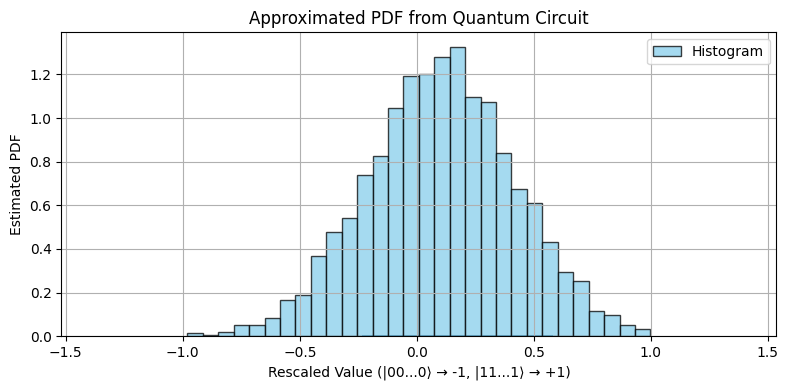

In [19]:
# Use TT cores from the 1-D example above
G = [elem.to(torch.complex128) for elem in qtt1.cores]
unitaries = tt_to_qc_gates(G)[::-1] # Reverse order for application

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

# Plot an approximated PDF from the measurement outcomes
estimated_probs = runner.plot_approximated_pdf_1d(counts, shots=n_shots, n_bins=30, plot=True)

[[-32 -31 -30 ...  -3  -2  -1]
 [-31 -30 -29 ...  -2  -1   0]
 [-30 -29 -28 ...  -1   0   1]
 ...
 [ -3  -2  -1 ...  26  27  28]
 [ -2  -1   0 ...  27  28  29]
 [ -1   0   1 ...  28  29  30]]
Truncated Fourier matrix shape: (32, 32)
Kept bond dimension: 8
Truncation error (||hat_f - A@B||_F): 6.09e-06


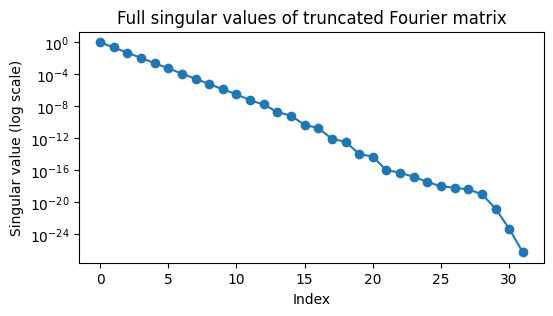

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_truncated_fourier_2d(cov, m, a):
    """
    Compute truncated Fourier coefficients for a 2D normal distribution.
    
    Args:
        cov (array-like, shape (2,2)): covariance matrix
        m (int): keep M = 2**m low-frequency coefficients per dimension
        a (float): range parameter (x in [-a/2, a/2])
        
    Returns:
        hat_f (np.ndarray): shape (M, M) of (complex) Fourier coefficients
    """
    M = 2**m
    # wavenumbers k in [-M/2, M/2-1]
    ks = np.arange(-M//2, M//2)
    k1, k2 = np.meshgrid(ks, ks, indexing='ij')
    inv_cov = np.linalg.inv(cov)
    # Compute exponent factor
    alpha = (2*np.pi/a)**2
    # Quadratic form k^T Σ k = [k1 k2] Σ [k1; k2]
    expo = alpha * (inv_cov[0,0]*k1**2 + 2*inv_cov[0,1]*k1*k2 + inv_cov[1,1]*k2**2)
    # (-1)^(k1+k2) factor
    print(k1+k2)
    parity = (-1.0)**(k1 + k2)
    hat_f = parity * np.exp(-0.5 * expo)
    # Normalize so sum |hat_f|^2 = 1
    norm = np.linalg.norm(hat_f)
    hat_f /= norm
    return hat_f

def mps_decompose_2d(array_2d, chi=None, eps=None):
    """
    Perform SVD on a 2D array and truncate to bond dimension chi or threshold eps.
    
    Returns left core A (N x r), singular values S (r,), right core B (r x N), and truncation error.
    """
    U, S_full, Vh = np.linalg.svd(array_2d, full_matrices=False)
    # determine r
    if chi is not None:
        r = min(chi, len(S_full))
    elif eps is not None:
        cum_sq = np.cumsum(S_full**2)
        total = cum_sq[-1]
        keep = np.where(1 - cum_sq/total <= eps**2)[0]
        r = keep[0]+1 if keep.size else len(S_full)
    else:
        r = len(S_full)
    S = S_full[:r]
    trunc_err = np.linalg.norm(S_full[r:])
    sqrtS = np.sqrt(S)
    # cores
    A = U[:, :r] * sqrtS
    B = (sqrtS[:, None] * Vh[:r, :])
    return A, S, B, trunc_err

# Example demonstration
cov = np.array([[1.0, 0.6], [0.6, 2.0]])
m = 5
a = 10.0
chi = 8

hat_f = compute_truncated_fourier_2d(cov, m, a)
A, S, B, err = mps_decompose_2d(hat_f, chi=chi)

# Display summary
print(f"Truncated Fourier matrix shape: {hat_f.shape}")
print(f"Kept bond dimension: {len(S)}")
print(f"Truncation error (||hat_f - A@B||_F): {err:.2e}")

# Plot the singular value spectrum
plt.figure(figsize=(6,3))
plt.semilogy(S_full := np.linalg.svd(hat_f, compute_uv=False), 'o-')
plt.title("Full singular values of truncated Fourier matrix")
plt.xlabel("Index")
plt.ylabel("Singular value (log scale)")
plt.show()


##### 2-D circuit and heatmap with sequential TT-cross

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0   | eps: 3.817e-07 | time:   0.0131 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 0.001616s (8.39e+05 evals/s)

[torch.Size([1, 2, 2]), torch.Size([2, 2, 4]), torch.Size([4, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 4]), torch.Size([4, 2, 2]), torch.Size([2, 2, 1])]
[torch.Size([4, 4]), torch.Size([8, 8]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([8, 8]), torch.Size([4, 4]), torch.Size([2, 2])]
Number of qubits: 10
Circuit depth: 11


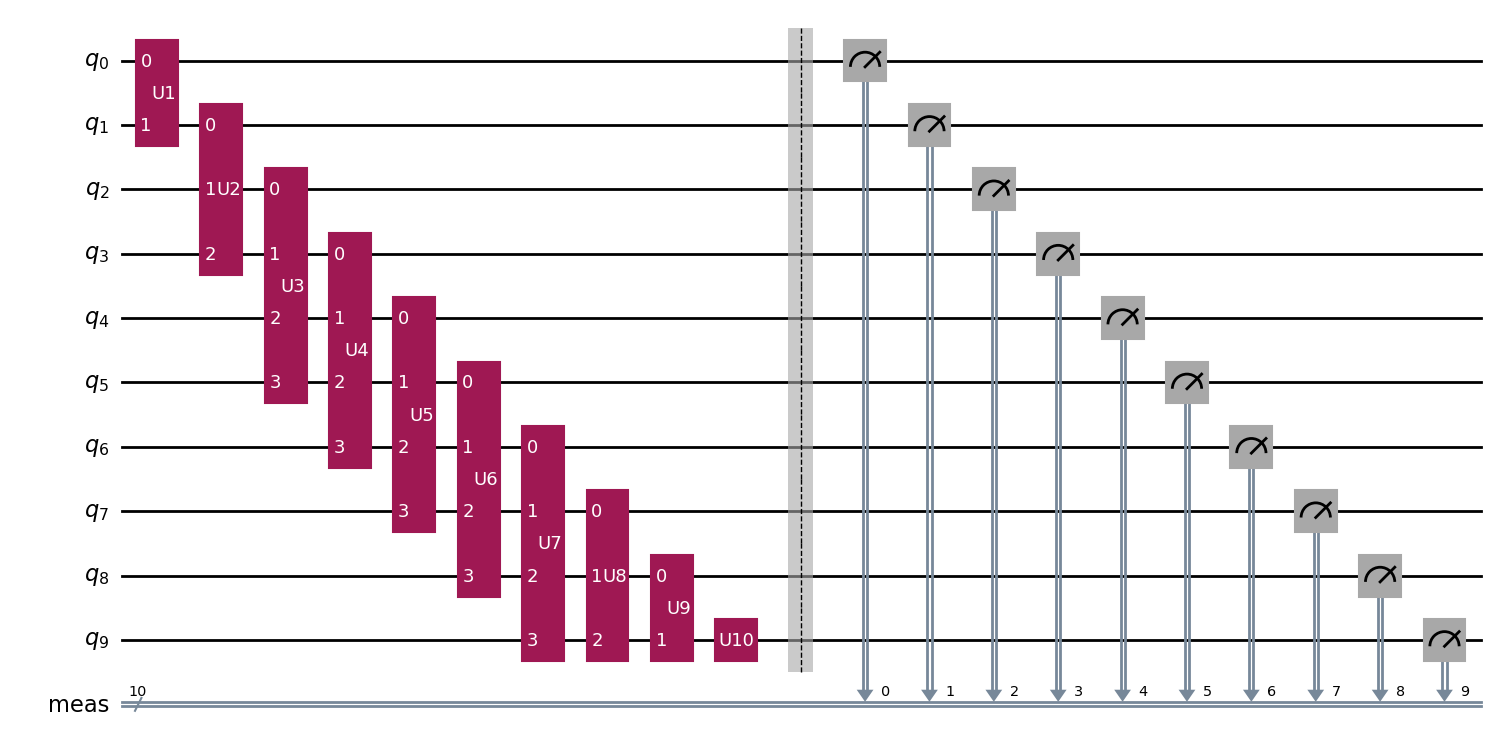

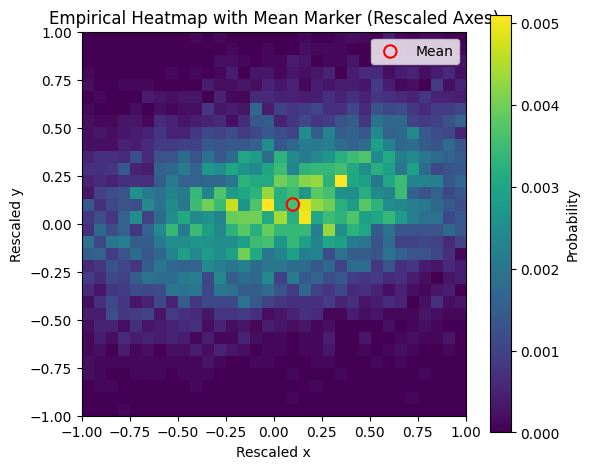

In [20]:
d = 2
bond_dim = 8
n_qubits = 5
mu, cov_matrix = gaussian_parameters[2]
qtt2_seq, info = create_tensor_network(
        bond_dim=bond_dim,
        n_qubits_per_dim=n_qubits,
        mu=mu,
        cov_matrix=cov_matrix,
        grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
        encoding='sequential',
        verbose=True
    )

G = [g_k.to(torch.complex128) for g_k in qtt2_seq.cores]
print([e.shape for e in G])
unitaries = tt_to_qc_gates(G)[::-1]
print([e.shape for e in unitaries])

# [::-1] # Reverse order for application

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

# Plot an approximated PDF from the measurement outcomes
estimated_probs = runner.plot_approximated_pdf_2d(counts, shots=n_shots, encoding='sequential')

##### 2-D circuit and heatmap with mirroring TT-cross

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0   | eps: 4.791e-07 | time:   0.0156 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 0.00227s (5.974e+05 evals/s)

[torch.Size([1, 2, 2]), torch.Size([2, 2, 4]), torch.Size([4, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 8]), torch.Size([8, 2, 4]), torch.Size([4, 2, 2]), torch.Size([2, 2, 1])]
[torch.Size([4, 4]), torch.Size([8, 8]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([8, 8]), torch.Size([4, 4]), torch.Size([2, 2])]
Number of qubits: 10
Circuit depth: 11


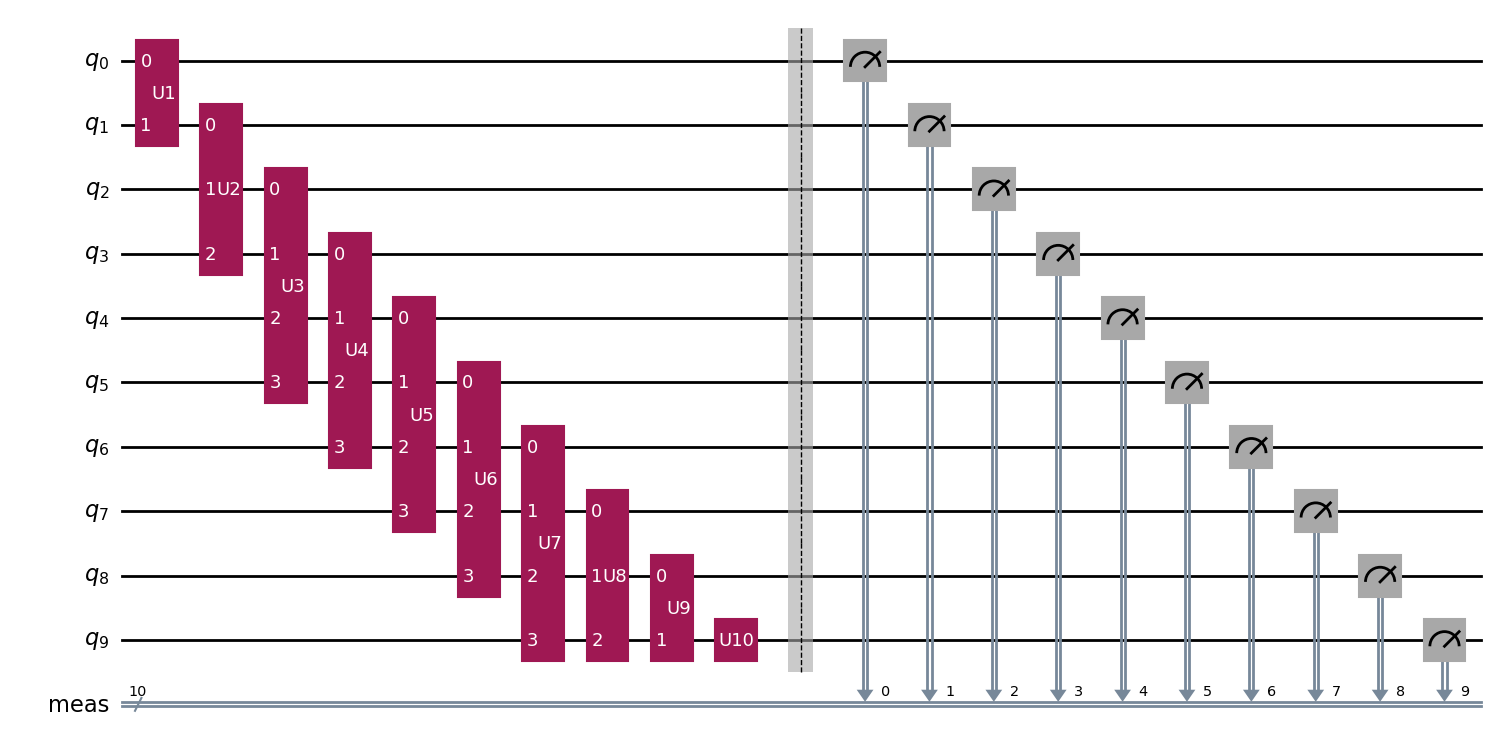

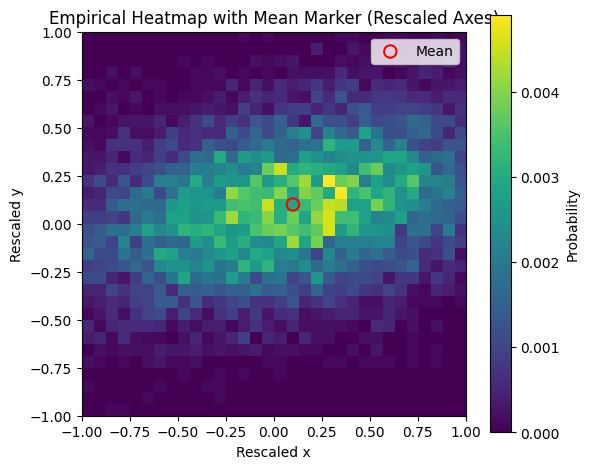

In [21]:
d = 2
bond_dim = 8
n_qubits = 5
mu, cov_matrix = gaussian_parameters[2]
qtt2_mirror, info = create_tensor_network(
        bond_dim=bond_dim,
        n_qubits_per_dim=n_qubits,
        mu=mu,
        cov_matrix=cov_matrix,
        grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
        encoding='mirroring',
        verbose=True
    )

G = [g_k.to(torch.complex128) for g_k in qtt2_mirror.cores]
print([e.shape for e in G])
unitaries = tt_to_qc_gates(G)[::-1]
print([e.shape for e in unitaries])

# [::-1] # Reverse order for application

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

# Plot an approximated PDF from the measurement outcomes
estimated_probs = runner.plot_approximated_pdf_2d(counts, shots=n_shots, encoding='mirroring')

##### 2-D circuit and heatmap with interleaved TT-cross

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0   | eps: 5.863e-03 | time:   0.0149 | largest rank:   8
iter: 1   | eps: 3.746e-03 | time:   0.0286 | largest rank:   8
iter: 2   | eps: 3.660e-03 | time:   0.0411 | largest rank:   8
iter: 3   | eps: 3.226e-03 | time:   0.0531 | largest rank:   8
iter: 4   | eps: 2.497e-03 | time:   0.0652 | largest rank:   8
iter: 5   | eps: 2.405e-03 | time:   0.0770 | largest rank:   8
iter: 6   | eps: 3.152e-03 | time:   0.0886 | largest rank:   8
iter: 7   | eps: 3.650e-03 | time:   0.1004 | largest rank:   8
iter: 8   | eps: 3.660e-03 | time:   0.1122 | largest rank:   8
iter: 9   | eps: 3.660e-03 | time:   0.1238 | largest rank:   8
iter: 10  | eps: 3.660e-03 | time:   0.1353 | largest rank: 

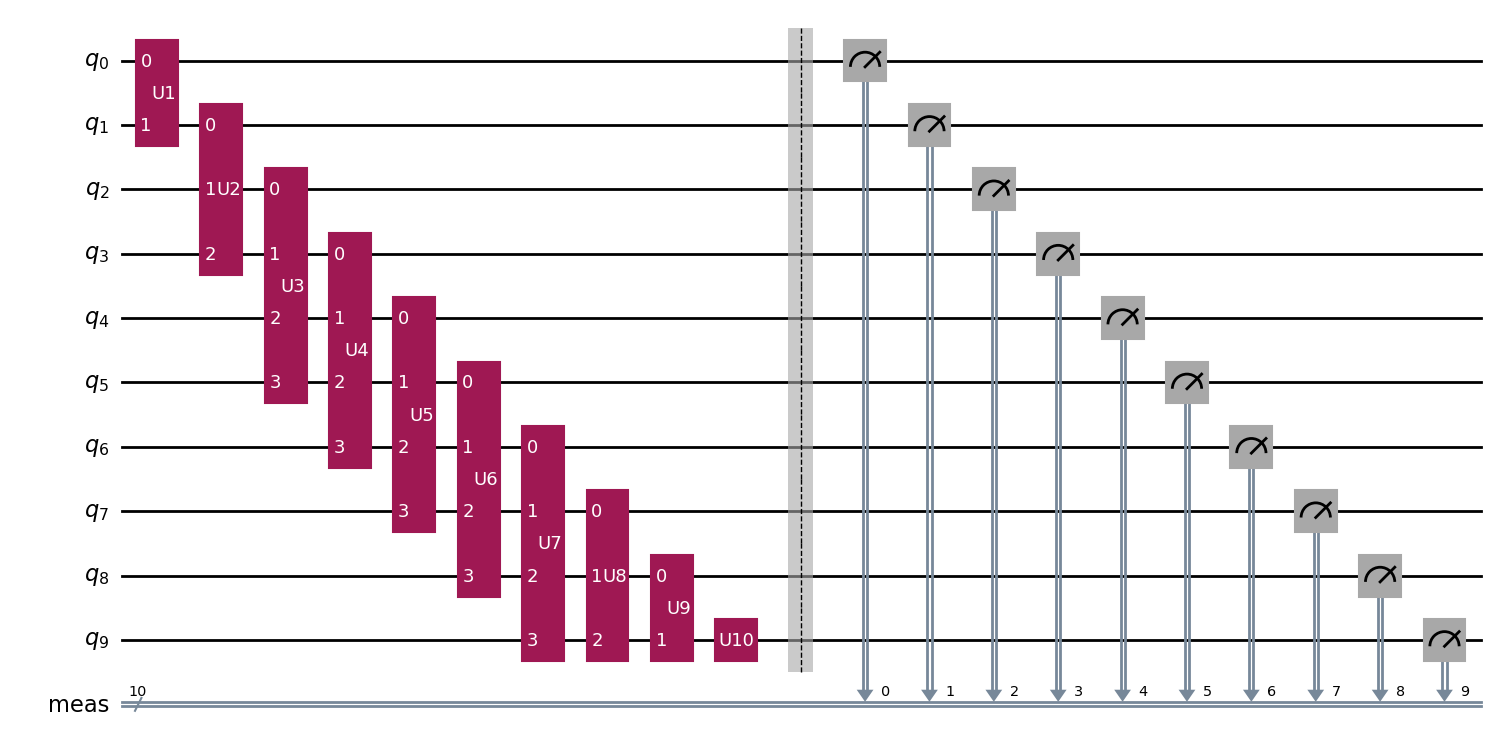

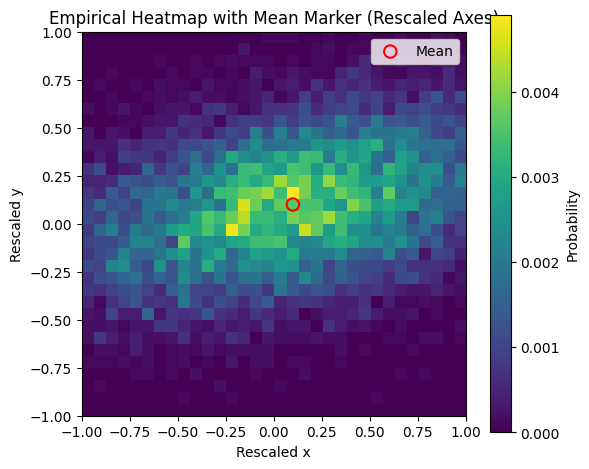

In [22]:
d = 2
bond_dim = 8
n_qubits = 5
mu, cov_matrix = gaussian_parameters[2]
qtt2_inter, info = create_tensor_network(
        bond_dim=bond_dim,
        n_qubits_per_dim=n_qubits,
        mu=mu,
        cov_matrix=cov_matrix,
        grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
        encoding='interleaved',
        verbose=True
    )

G = [g_k.to(torch.complex128) for g_k in qtt2_inter.cores]
print([e.shape for e in G])
unitaries = tt_to_qc_gates(G)[::-1]
print([e.shape for e in unitaries])

# [::-1] # Reverse order for application

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

# Plot an approximated PDF from the measurement outcomes
estimated_probs = runner.plot_approximated_pdf_2d(counts, shots=n_shots, encoding='interleaved')

##### 4-D circuit with sequential TT-cross

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 12D domain containing 4096 grid points:
iter: 0   | eps: 3.710e-02 | time:   0.0240 | largest rank:  32
iter: 1   | eps: 1.428e-02 | time:   0.0471 | largest rank:  32
iter: 2   | eps: 1.402e-02 | time:   0.0700 | largest rank:  32
iter: 3   | eps: 1.402e-02 | time:   0.0928 | largest rank:  32
iter: 4   | eps: 1.402e-02 | time:   0.1153 | largest rank:  32
iter: 5   | eps: 1.402e-02 | time:   0.1375 | largest rank:  32
iter: 6   | eps: 1.402e-02 | time:   0.1595 | largest rank:  32
iter: 7   | eps: 1.402e-02 | time:   0.1823 | largest rank:  32
iter: 8   | eps: 1.402e-02 | time:   0.2061 | largest rank:  32
iter: 9   | eps: 1.402e-02 | time:   0.2295 | largest rank:  32
iter: 10  | eps: 1.402e-02 | time:   0.2528 | largest rank: 

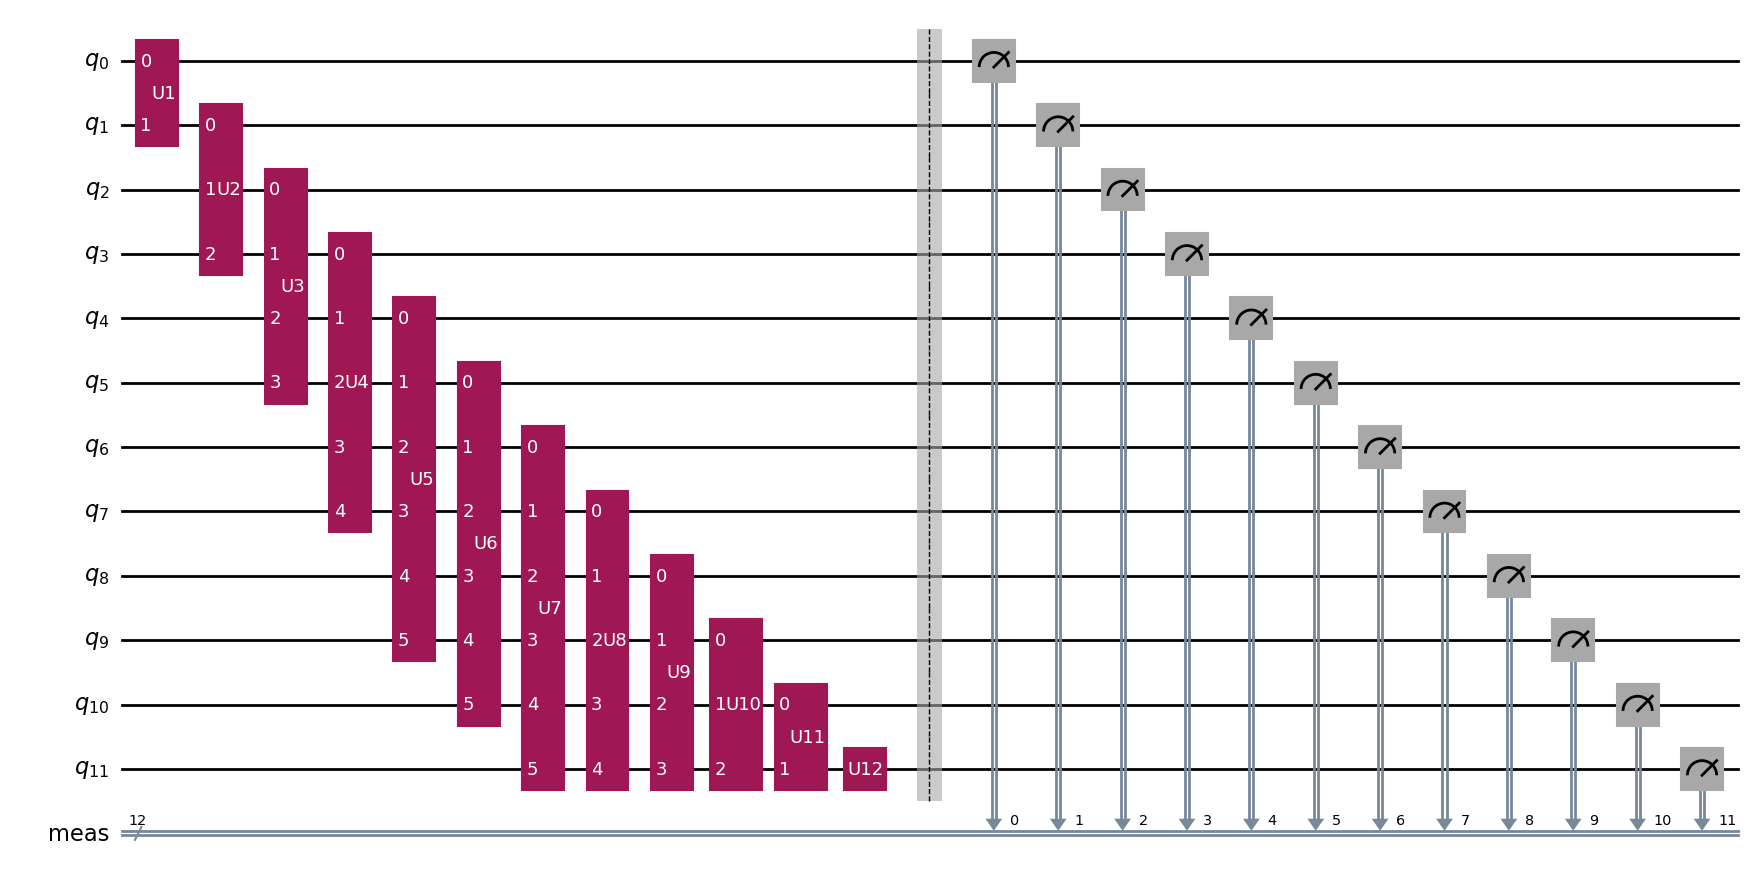

In [23]:
d = 4
bond_dim = 32
n_qubits = 3
mu, cov_matrix = gaussian_parameters[d]
qtt4_seq, info = create_tensor_network(
        bond_dim=bond_dim,
        n_qubits_per_dim=n_qubits,
        mu=mu,
        cov_matrix=cov_matrix,
        grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
        encoding='sequential',
        verbose=True
    )
    
G = [g_k.to(torch.complex128) for g_k in qtt4_seq.cores]
unitaries = tt_to_qc_gates(G)[::-1]

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

#### 4-D circuit with interleaved TT-cross

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 12D domain containing 4096 grid points:
iter: 0   | eps: 8.015e-02 | time:   0.0240 | largest rank:  32
iter: 1   | eps: 2.500e-02 | time:   0.0478 | largest rank:  32
iter: 2   | eps: 2.190e-02 | time:   0.0716 | largest rank:  32
iter: 3   | eps: 2.190e-02 | time:   0.0954 | largest rank:  32
iter: 4   | eps: 2.190e-02 | time:   0.1178 | largest rank:  32
iter: 5   | eps: 2.190e-02 | time:   0.1404 | largest rank:  32
iter: 6   | eps: 2.190e-02 | time:   0.1629 | largest rank:  32
iter: 7   | eps: 2.190e-02 | time:   0.1873 | largest rank:  32
iter: 8   | eps: 2.190e-02 | time:   0.2128 | largest rank:  32
iter: 9   | eps: 2.190e-02 | time:   0.2385 | largest rank:  32
iter: 10  | eps: 2.190e-02 | time:   0.2646 | largest rank: 

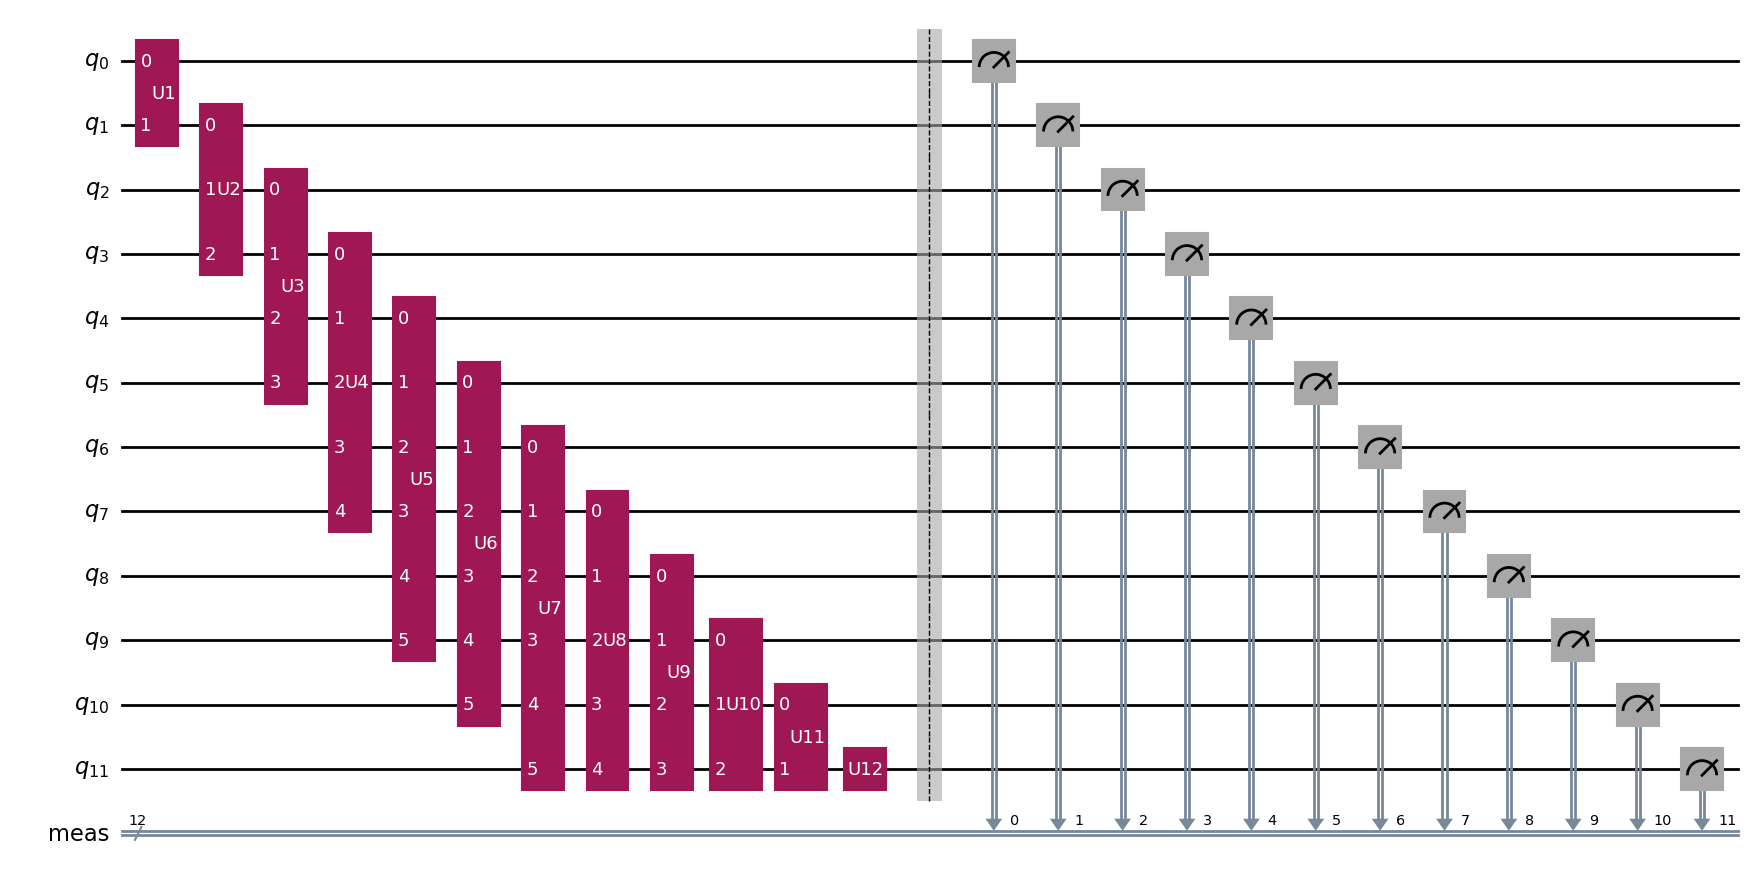

In [24]:
d = 4
bond_dim = 32
n_qubits = 3
mu, cov_matrix = gaussian_parameters[d]
qtt4_seq, info = create_tensor_network(
        bond_dim=bond_dim,
        n_qubits_per_dim=n_qubits,
        mu=mu,
        cov_matrix=cov_matrix,
        grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
        encoding='interleaved',
        verbose=True
    )
    
G = [g_k.to(torch.complex128) for g_k in qtt4_seq.cores]
unitaries = tt_to_qc_gates(G)[::-1]

# Build and simulate the quantum circuit
runner = UnitaryCircuitRunner(unitaries)
runner.build_circuit()
runner.circuit.measure_all()  # Ensure measurement before plotting
print("Number of qubits:", runner.get_num_qubits())
print("Circuit depth:", runner.get_circuit_depth())

# Plot the circuit
fig = runner.plot_circuit()
display(fig)

# Run the simulation and get measurement results
n_shots = 10000
counts = runner.run(shots=n_shots)

At first glance we observe that change the encoding to ``mirroring`` or ``interleaved`` does not improve the results, and sometimes even makes the approximation worse (see 2-D example). However, these quantization methods can play a significant role when we account for the correlation between the parameters correctly. Consider an 4-d multivariate normal distribution, where 1st and 3rd parameters are highly correlated and the bond dimension is small. In that case, permuting the indices so that the correlated parameters are connected makes a big difference.

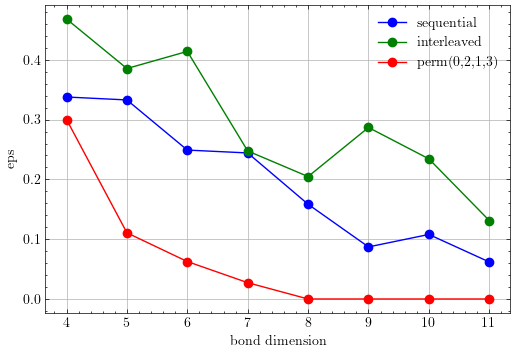

In [ ]:
mu = np.array([0.1]*4)
cov_matrix = np.array([
    [1.0, 0.0, 0.95, 0.0], 
    [0.0, 1.0, 0.0, 0.0], 
    [0.95, 0.0, 1.0, 0.0], 
    [0.0, 0.0, 0.0, 1.0]
])

d = 4
n_qubits = 3

encoding_list = ['sequential', 'interleaved', 'perm(0,2,1,3)']
bond_dim_list = list(range(4, 12))
eps_encoding = {e: [] for e in encoding_list}
eps_seq = []
eps_int = []
eps_perm = []

for i, encoding in enumerate(encoding_list):
    print(i)
    for bond_dim in bond_dim_list:
        qtt4_seq, info = create_tensor_network(
            bond_dim=bond_dim,
            n_qubits_per_dim=n_qubits,
            mu=mu,
            cov_matrix=cov_matrix,
            grids=[np.linspace(-1, 1, 2**n_qubits)]*d,
            encoding=encoding,
            verbose=False
        )
        eps_encoding[encoding].append(info["val_eps"])

plt.figure(figsize=(6, 4))  # Increase figure size here
colors = ['b', 'g', 'r']
for i, encoding in enumerate(encoding_list):
    style = 'o-'
    if i < len(colors):
        style = colors[i] + style
    plt.plot(bond_dim_list, eps_encoding[encoding], style, label=encoding)


plt.xlabel('bond dimension')
plt.ylabel('eps')
plt.legend()
plt.grid()
plt.show()


#### STEP 5 -- Comparing with the target probability distribution

In this section you will calculate the metrics mentioned in [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) with the aim to evaluate the quality of the results. For this you will calculate a distance that measures the difference between cumulative distribution functions of probability distributions, the circuit depth as well as the time.

Use the Tensor Network create in **STEP 1** to compute the metrics below for the following cases:
- Univariate case ($n_{\text{dimensions}}=1$)
- $n_{\text{dimensions}}=2,4$

##### Kolmogorov-Simrnov distance
The Kolmogorov-Simrnov distance is used to measure the maximum difference between two cumulative distribution functions of two probability distributions. It is defined as:

$$D = \sup_{x} | F(x)-G(x)| $$

with $F(x)$ and $G(x)$ two **cumulative distribution functions**, $\sup_{x}$ the supremum over all values of $x$. Note that the supremum is a concept used in real analysis and order theory to describe the smallest value that is greater than or equal to every element in a given set. $F(x)$ is the **exact distribution** and $G(x)$ the one approximated with Tensor Networks. As the **exact distribution**, use the numerical value of the probability distribution presented in **Section 1**.


**Cumulative distribution:**  For a random variable ($X$), the cumulative distribution function ($F(x)$) is defined as:

$F(x) = P(X \leq x)$

This means $F(x)$ gives the probability that the random variable $X$ is less than or equal to $x$.

Plot the **Kolmogorov-Simrnov distance = f(number of qubits)** for different bond dimensions of the Tensor Network between **the TT-cross approximation** and **the exact**, as indicated in the left part of figure 4 in paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660). What are your observations?

Additionally, one can also plot the **Kullback-Leibler (KL) Divergence = f(number of qubits)**. See page 15 of [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

##### Circuit Depth

Plot the **circuit depth = f(number of qubits)**. What are your observations?

##### Training time

Plot the **time = f(number of qubits)**. Here consider different times (the time to create the Tensor Network, the time to transform that to a circuit). What are your observations?

**Answer:**

### 1D - Experiments


=== Running for bond dimension 2 ===

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be in

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.



=== Running for bond dimension 4 ===

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be in

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.



=== Running for bond dimension 8 ===

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be in

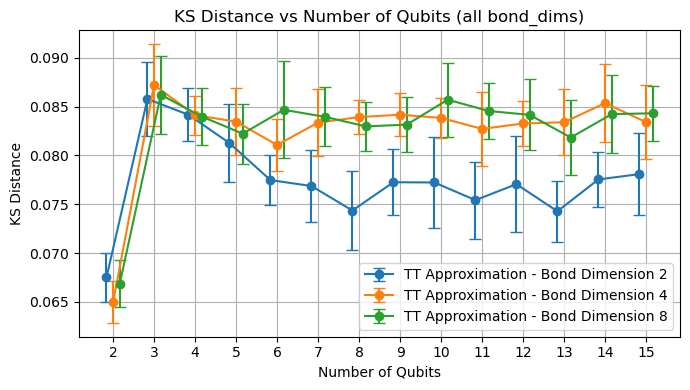

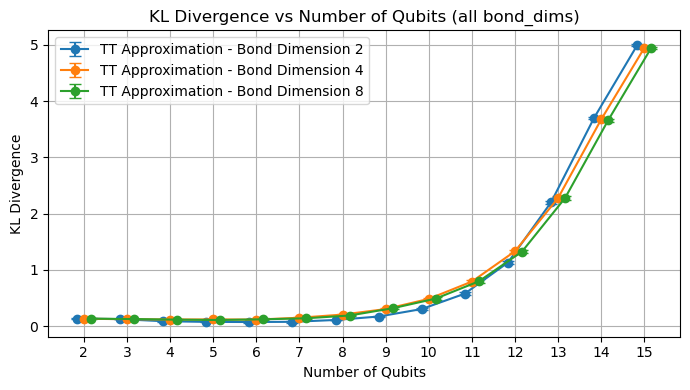

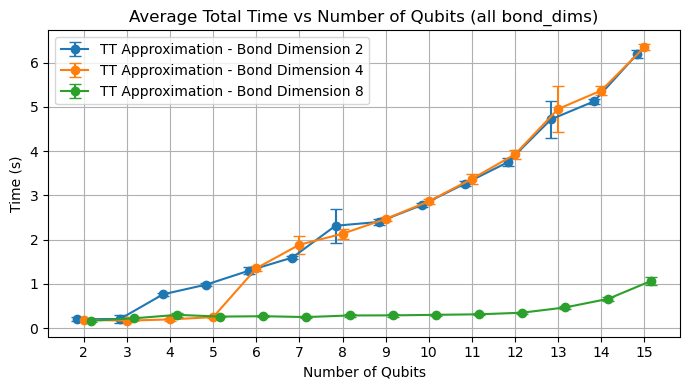

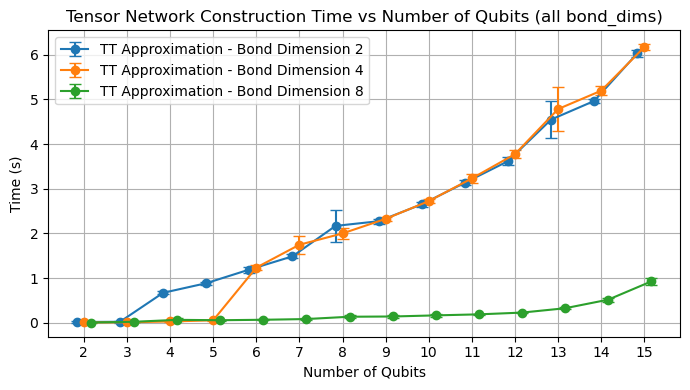

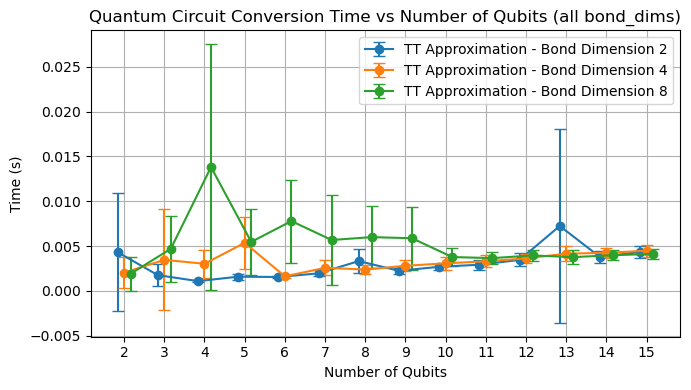

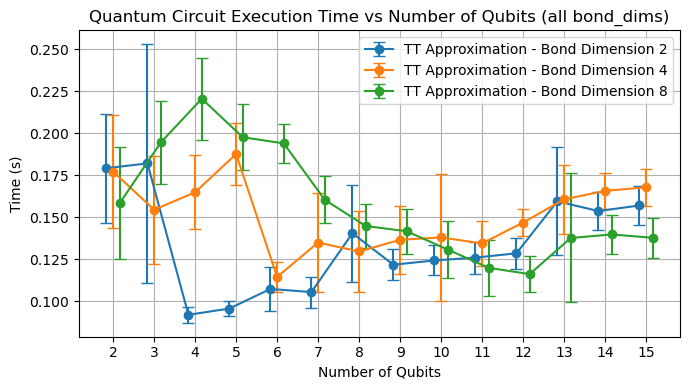

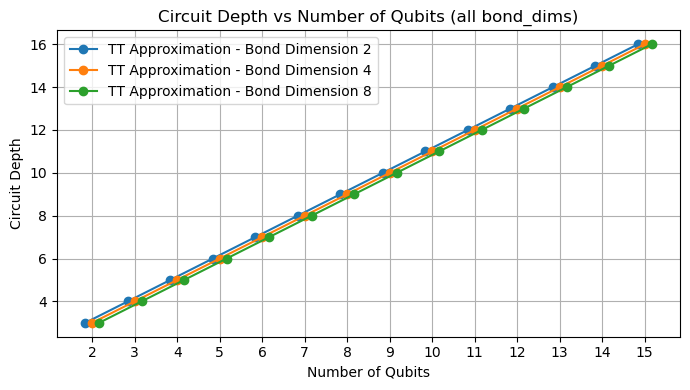

In [ ]:
import numpy as np
import torch
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def gaussian_pdf_dict(mu, cov_matrix, x, num_qubits, plot=False):
    y = multivariate_normal.pdf(x, mean=mu, cov=cov_matrix)
    binary_y_dict = {}
    for i, y_val in enumerate(y):
        binary_str = format(i, f'0{num_qubits}b')
        binary_y_dict[binary_str] = y_val

    if plot:
        # If x is 1D, plot x vs y. If x is 2D, plot first dimension vs y.
        if x.ndim == 1:
            plt.plot(x, y, marker='o')
            plt.xlabel('x')
        else:
            plt.plot(x[:, 0], y, marker='o')
            plt.xlabel('x[:, 0]')
        plt.ylabel('PDF value')
        plt.title('Multivariate Gaussian PDF')
        plt.show()

    return binary_y_dict

def compute_cdf(distribution):
    """
    Given a dict mapping bitstrings to probabilities, return a dict mapping bitstrings to normalized CDF values.
    The CDF is computed in lexicographical order of bitstrings.
    """
    # Sort bitstrings lexicographically
    sorted_bitstrings = sorted(distribution.keys())
    cdf = {}
    cumulative = 0.0
    total = sum(distribution.values())
    for b in sorted_bitstrings:
        cumulative += distribution[b]
        cdf[b] = cumulative / total if total != 0 else 0.0
    return cdf

def plot_cdf(dist1, dist2, title="CDF Comparison"):
    """
    Plot the CDFs of two distributions (dicts mapping bitstrings to probabilities).
    """
    # Compute CDFs
    cdf1 = compute_cdf(dist1)
    cdf2 = compute_cdf(dist2)
    # Sort bitstrings lexicographically
    sorted_keys1 = sorted(cdf1.keys())
    sorted_keys2 = sorted(cdf2.keys())
    # Convert bitstrings to integers for x-axis
    x1 = [int(k, 2) for k in sorted_keys1]
    x2 = [int(k, 2) for k in sorted_keys2]
    y1 = [cdf1[k] for k in sorted_keys1]
    y2 = [cdf2[k] for k in sorted_keys2]
    plt.figure(figsize=(8, 4))
    plt.plot(x1, y1, label='dist1 (target)', marker='o')
    plt.plot(x2, y2, label='dist2 (approx)', marker='x')
    plt.xlabel('Bitstring (as integer)')
    plt.ylabel('CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def normalize_pdf(pdf_dict):
    """
    Normalize a discrete probability density function (PDF) stored as a dict.

    Args:
        pdf_dict (dict): Unnormalized probability values, e.g., {x1: p1, x2: p2, ...}

    Returns:
        dict: Normalized probability values (sum to 1), same keys as input.
    """
    total = sum(pdf_dict.values())
    if total == 0:
        raise ValueError("Sum of PDF values is zero; cannot normalize.")
    return {k: v / total for k, v in pdf_dict.items()}

def ks_distance(dist1, dist2):
    """
    Compute the Kolmogorov-Smirnov (KS) distance between two distributions.
    Both inputs are dicts mapping bitstrings to probabilities.
    """
    # Get all bitstrings
    all_bitstrings = sorted(set(dist1.keys()))
    # Fill missing keys with 0
    p1 = dist1
    p2 = {b: dist2.get(b, 0.0) for b in all_bitstrings}
    # Compute CDFs
    cdf1 = compute_cdf(p1)
    cdf2 = compute_cdf(p2)
    # Compute KS distance
    ks = max(abs(cdf1[b] - cdf2[b]) for b in all_bitstrings)
    return ks

def kl_divergence(dict1, dict2):
    """
    Compute the KL divergence D_KL(dict1 || dict2), where dict1 is the true distribution
    and dict2 is the approximate distribution.
    Both inputs are dicts mapping bitstrings to probabilities.
    Returns (kl_divergence, q_zero_count)
    """
    all_bitstrings = sorted(set(dict1.keys()))

    # Normalize both distributions
    dict1 = normalize_pdf(dict1)
    dict2 = normalize_pdf(dict2)

    kl = 0.0
    q_zero_count = 0  # Counter for q == 0
    for b in all_bitstrings:
        p = dict1.get(b, 0.0)
        q = dict2.get(b, 0.0)
        if p == 0:
            continue
        if q == 0:
            q_zero_count += 1
            q += 1e-8  # Avoid division by zero
        kl += p * np.log(p / q)
    return kl, q_zero_count

def plot_metric_vs_qubits_all_bond_dims(results_by_bond_dim, metric_mean, metric_std=None, ylabel="", title="", shift_percent=0.025):
    """
    Plot a metric vs number of qubits for all bond_dims on the same plot.
    If metric_std is provided, plot error bars.
    Each bond_dim's points are slightly shifted to avoid overlap.
    The shift is shift_percent (default 5%) of the x-axis width.
    """
    plt.figure(figsize=(7, 4))
    bond_dims = sorted(results_by_bond_dim.keys())
    n_bond_dims = len(bond_dims)

    # Get all unique x values (num_qubits)
    all_x = sorted({r['num_qubits'] for results in results_by_bond_dim.values() for r in results})
    x_min, x_max = min(all_x), max(all_x)
    x_range = x_max - x_min if x_max > x_min else 1  # avoid division by zero

    # Calculate total shift width in data units (e.g., 5% of x_range)
    total_shift = shift_percent * x_range

    for i, bond_dim in enumerate(bond_dims):
        results = results_by_bond_dim[bond_dim]
        x = np.array([r['num_qubits'] for r in results])
        y = np.array([r[metric_mean] for r in results])
        # Calculate shift: center around 0
        shift = total_shift * (i - (n_bond_dims - 1) / 2) / max(n_bond_dims-1, 1)
        x_shifted = x + shift
        label = f"TT Approximation - Bond Dimension {bond_dim}"
        if metric_std is not None:
            yerr = np.array([r[metric_std] for r in results])
            plt.errorbar(x_shifted, y, yerr=yerr, fmt='o-', capsize=4, label=label)
        else:
            plt.plot(x_shifted, y, 'o-', label=label)
    plt.xlabel('Number of Qubits')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    # Set xticks at original positions
    plt.xticks(all_x)
    plt.tight_layout()
    plt.show()


bond_dim_list = [2, 4, 8]
n_qubits_list = np.arange(2, 16, 1)  # 2 to 15 inclusive

mu, covm = gaussian_parameters[1]

results_by_bond_dim = {}

num_runs = 10

for bond_dim in bond_dim_list:
    print(f"\n=== Running for bond dimension {bond_dim} ===\n")
    aggregated_results = []

    for n_qubits in n_qubits_list:
        grid = np.linspace(-1, 1, 2**n_qubits)
        qtt1, info = create_tensor_network(
            bond_dim=bond_dim,
            n_qubits_per_dim=n_qubits,
            mu=[mu],
            cov_matrix=covm,
            grids=[grid]
        )
        G = [elem.to(torch.complex128) for elem in qtt1.cores]
        unitaries = tt_to_qc_gates(G)[::-1]

        ks_list, kl_list, total_time_list, q_zero_count_list = [], [], [], []
        tn_construct_time_list, qc_convert_time_list, qc_run_time_list = [], [], []

        for run in range(num_runs):
            # Timer: tensor network construction
            start_tn = time.time()
            qtt1, info = create_tensor_network(
                bond_dim=bond_dim,
                n_qubits_per_dim=n_qubits,
                mu=[mu],
                cov_matrix=covm,
                grids=[grid]
            )
            tn_construct_time = time.time() - start_tn
            tn_construct_time_list.append(tn_construct_time)

            # Timer: circuit conversion
            start_convert = time.time()
            G = [elem.to(torch.complex128) for elem in qtt1.cores]
            unitaries = tt_to_qc_gates(G)[::-1]
            qc_convert_time = time.time() - start_convert
            qc_convert_time_list.append(qc_convert_time)

            # Timer: run circuit
            start_run = time.time()
            runner = UnitaryCircuitRunner(unitaries)
            runner.build_circuit()
            runner.circuit.measure_all()

            num_qubits_actual = runner.get_num_qubits()
            circuit_depth = runner.get_circuit_depth()

            counts = runner.run(shots=10000)
            estimated_probs = runner.plot_approximated_pdf_1d(counts, shots=10000, n_bins=64, plot=False)
            qc_run_time = time.time() - start_run
            qc_run_time_list.append(qc_run_time)

            # Evaluate metrics
            dist1 = gaussian_pdf_dict(mu, covm, grid, n_qubits, plot=False)
            dist2 = estimated_probs
            ks = ks_distance(dist1, dist2)
            kl, q_zero_count = kl_divergence(dist1, dist2)

            ks_list.append(ks)
            kl_list.append(kl)
            total_time_list.append(tn_construct_time + qc_convert_time + qc_run_time)
            q_zero_count_list.append(q_zero_count)

        aggregated_results.append({
            'bond_dim': bond_dim,
            'num_qubits': num_qubits_actual,
            'circuit_depth': circuit_depth,
            'ks_mean': np.mean(ks_list),
            'ks_std': np.std(ks_list),
            'kl_mean': np.mean(kl_list),
            'kl_std': np.std(kl_list),
            'time_mean': np.mean(total_time_list),
            'time_std': np.std(total_time_list),
            'tn_construct_time_mean': np.mean(tn_construct_time_list),
            'tn_construct_time_std': np.std(tn_construct_time_list),
            'qc_convert_time_mean': np.mean(qc_convert_time_list),
            'qc_convert_time_std': np.std(qc_convert_time_list),
            'qc_run_time_mean': np.mean(qc_run_time_list),
            'qc_run_time_std': np.std(qc_run_time_list),
            'q_zero_count_mean': np.mean(q_zero_count_list),
            'q_zero_count_std': np.std(q_zero_count_list)
        })

    results_by_bond_dim[bond_dim] = aggregated_results

# Print results
for bond_dim, results in results_by_bond_dim.items():
    print(f"\nAggregated Results for bond_dim={bond_dim}:")
    for result in results:
        print(result)

import pickle

# Save results_by_bond_dim to a file
with open('results_by_bond_dim.pkl', 'wb') as f:
    pickle.dump(results_by_bond_dim, f)
print("Saved results_by_bond_dim to results_by_bond_dim.pkl")

with open('results_by_bond_dim.pkl', 'rb') as f:
    results_by_bond_dim = pickle.load(f)

# Plots
plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='ks_mean',
    metric_std='ks_std',
    ylabel='KS Distance',
    title='KS Distance vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='kl_mean',
    metric_std='kl_std',
    ylabel='KL Divergence',
    title='KL Divergence vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='time_mean',
    metric_std='time_std',
    ylabel='Time (s)',
    title='Average Total Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='tn_construct_time_mean',
    metric_std='tn_construct_time_std',
    ylabel='Time (s)',
    title='Tensor Network Construction Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='qc_convert_time_mean',
    metric_std='qc_convert_time_std',
    ylabel='Time (s)',
    title='Quantum Circuit Conversion Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='qc_run_time_mean',
    metric_std='qc_run_time_std',
    ylabel='Time (s)',
    title='Quantum Circuit Execution Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='circuit_depth',
    metric_std=None,
    ylabel='Circuit Depth',
    title='Circuit Depth vs Number of Qubits (all bond_dims)'
)


=== Running for bond dimension 4 ===

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be in

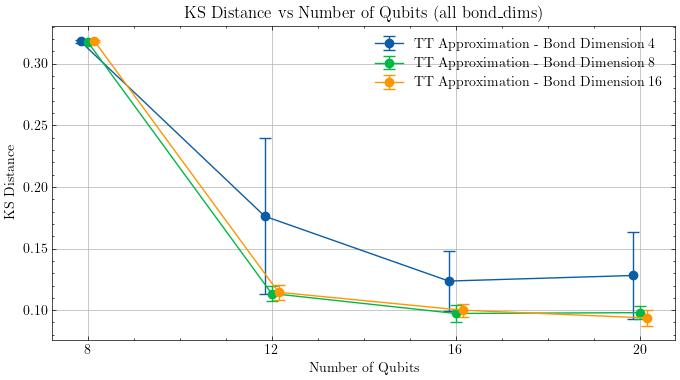

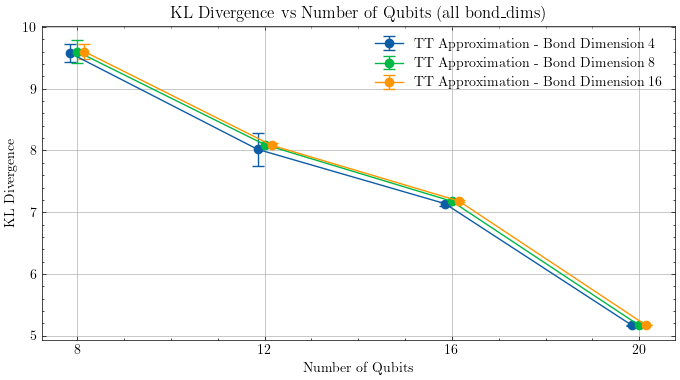

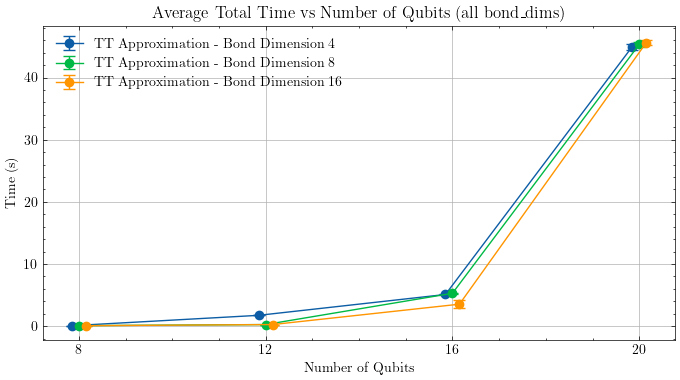

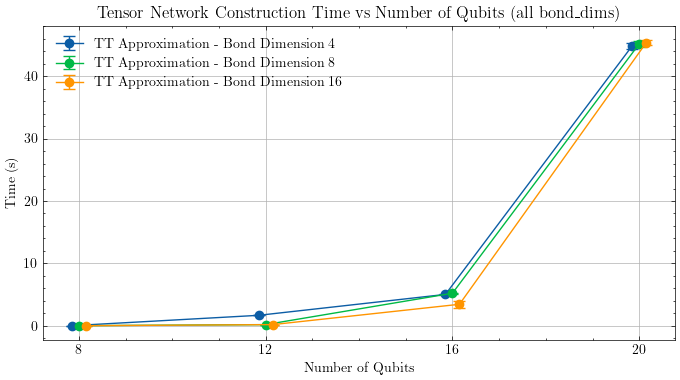

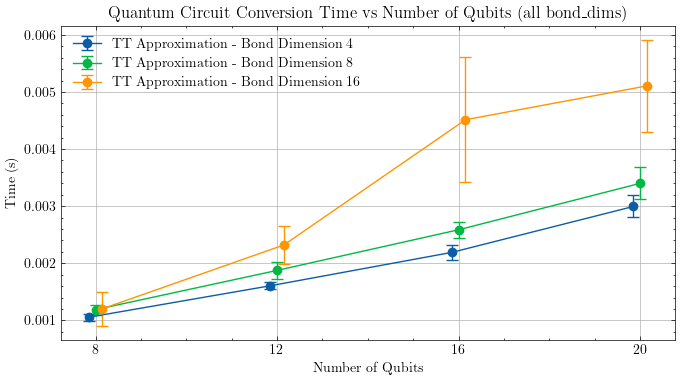

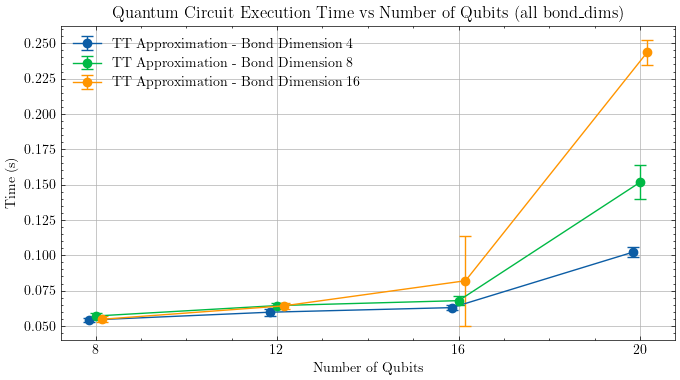

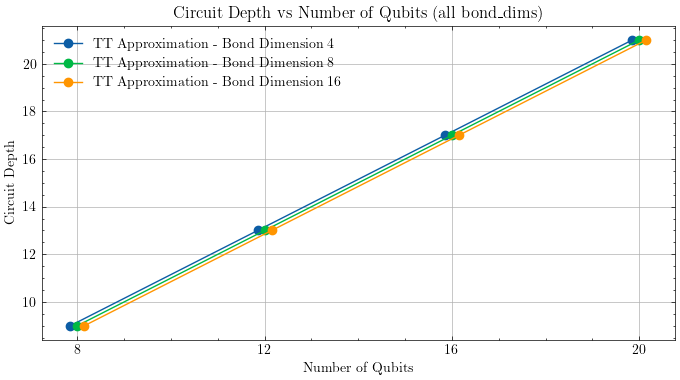

In [ ]:
d = 4
bond_dim_list = [4, 8, 16]
n_qubits_list = np.arange(2, 6, 1)  # 2 to 15 inclusive

mu = np.array([0.1]*4)
covm = np.array([
    [1.0, 0.0, 0.95, 0.0], 
    [0.0, 1.0, 0.0, 0.0], 
    [0.95, 0.0, 1.0, 0.0], 
    [0.0, 0.0, 0.0, 1.0]
])

results_by_bond_dim = {}

num_runs = 10

for bond_dim in bond_dim_list:
    print(f"\n=== Running for bond dimension {bond_dim} ===\n")
    aggregated_results = []

    for n_qubits in n_qubits_list:
        grid = np.linspace(-1, 1, 2**n_qubits)
        qtt1, info = create_tensor_network(
            bond_dim=bond_dim,
            n_qubits_per_dim=n_qubits,
            mu=mu,
            cov_matrix=covm,
            grids=[grid]*d,
            encoding='perm(0, 2, 1, 3)'
        )
        G = [elem.to(torch.complex128) for elem in qtt1.cores]
        unitaries = tt_to_qc_gates(G)[::-1]

        ks_list, kl_list, total_time_list, q_zero_count_list = [], [], [], []
        tn_construct_time_list, qc_convert_time_list, qc_run_time_list = [], [], []

        for run in range(num_runs):
            # Timer: tensor network construction
            start_tn = time.time()
            qtt1, info = create_tensor_network(
                bond_dim=bond_dim,
                n_qubits_per_dim=n_qubits,
                mu=mu,
                cov_matrix=covm,
                grids=[grid]*d,
                encoding='perm(0, 2, 1, 3)'
            )
            tn_construct_time = time.time() - start_tn
            tn_construct_time_list.append(tn_construct_time)

            # Timer: circuit conversion
            start_convert = time.time()
            G = [elem.to(torch.complex128) for elem in qtt1.cores]
            unitaries = tt_to_qc_gates(G)[::-1]
            qc_convert_time = time.time() - start_convert
            qc_convert_time_list.append(qc_convert_time)

            # Timer: run circuit
            start_run = time.time()
            runner = UnitaryCircuitRunner(unitaries)
            runner.build_circuit()
            runner.circuit.measure_all()

            num_qubits_actual = runner.get_num_qubits()
            circuit_depth = runner.get_circuit_depth()

            n_shots = 10000
            counts = runner.run(shots=n_shots)
            estimated_probs = {k: v / n_shots for k, v in counts.items()}
            qc_run_time = time.time() - start_run
            qc_run_time_list.append(qc_run_time)

            # Evaluate metrics
            grids = [grid]*d
            mesh = np.meshgrid(*grids, indexing='ij')
            x = np.stack([m.flatten() for m in mesh], axis=-1)
            dist1 = gaussian_pdf_dict(mu, covm, x, n_qubits, plot=False)
            dist2 = estimated_probs
            ks = ks_distance(dist1, dist2)
            kl, q_zero_count = kl_divergence(dist1, dist2)

            ks_list.append(ks)
            kl_list.append(kl)
            total_time_list.append(tn_construct_time + qc_convert_time + qc_run_time)
            q_zero_count_list.append(q_zero_count)

        aggregated_results.append({
            'bond_dim': bond_dim,
            'num_qubits': num_qubits_actual,
            'circuit_depth': circuit_depth,
            'ks_mean': np.mean(ks_list),
            'ks_std': np.std(ks_list),
            'kl_mean': np.mean(kl_list),
            'kl_std': np.std(kl_list),
            'time_mean': np.mean(total_time_list),
            'time_std': np.std(total_time_list),
            'tn_construct_time_mean': np.mean(tn_construct_time_list),
            'tn_construct_time_std': np.std(tn_construct_time_list),
            'qc_convert_time_mean': np.mean(qc_convert_time_list),
            'qc_convert_time_std': np.std(qc_convert_time_list),
            'qc_run_time_mean': np.mean(qc_run_time_list),
            'qc_run_time_std': np.std(qc_run_time_list),
            'q_zero_count_mean': np.mean(q_zero_count_list),
            'q_zero_count_std': np.std(q_zero_count_list)
        })

    results_by_bond_dim[bond_dim] = aggregated_results

# Print results
for bond_dim, results in results_by_bond_dim.items():
    print(f"\nAggregated Results for bond_dim={bond_dim}:")
    for result in results:
        print(result)

import pickle

# Save results_by_bond_dim to a file
with open('results_by_bond_dim_4d.pkl', 'wb') as f:
    pickle.dump(results_by_bond_dim, f)
print("Saved results_by_bond_dim to results_by_bond_dim_4d.pkl")

with open('results_by_bond_dim_4d.pkl', 'rb') as f:
    results_by_bond_dim = pickle.load(f)

# Plots
plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='ks_mean',
    metric_std='ks_std',
    ylabel='KS Distance',
    title='KS Distance vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='kl_mean',
    metric_std='kl_std',
    ylabel='KL Divergence',
    title='KL Divergence vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='time_mean',
    metric_std='time_std',
    ylabel='Time (s)',
    title='Average Total Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='tn_construct_time_mean',
    metric_std='tn_construct_time_std',
    ylabel='Time (s)',
    title='Tensor Network Construction Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='qc_convert_time_mean',
    metric_std='qc_convert_time_std',
    ylabel='Time (s)',
    title='Quantum Circuit Conversion Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='qc_run_time_mean',
    metric_std='qc_run_time_std',
    ylabel='Time (s)',
    title='Quantum Circuit Execution Time vs Number of Qubits (all bond_dims)'
)

plot_metric_vs_qubits_all_bond_dims(
    results_by_bond_dim,
    metric_mean='circuit_depth',
    metric_std=None,
    ylabel='Circuit Depth',
    title='Circuit Depth vs Number of Qubits (all bond_dims)'
)

**Note:** the images of this section were taken from the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

### BONUS - Section 3: Quantum Generative Adversarial Networks (qGAN)

<div class="alert alert-block alert-success"> 

For this step, if you choose the Pennylane road, you will need to install [Pennylane](https://pennylane.ai/) and [PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). You might need to install more libraries for this road. If you choose the Qiskit road you need to install qiskit-machine-learning=0.7.1, qiskit=0.45, qiskit_algorithms=0.2.2, torch, matplotlib, pylatexenc.

</div>

For this section, you can use one of the following:

- **Qiskit:** Follow the tutorial of Qiskit [Qiskit qGAN tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/04_torch_qgan.html) which introduces qGAN to learn the probability distribution. The final step of the tutorial calculates the cumulative distribution functions of the generated distribution as well as the difference between the original and the generated distribution.

- **Pennylane:** Instead of implementing qGAN with Qiskit, use [PennyLane](https://docs.pennylane.ai/en/stable/introduction/pennylane.html). One could have a look at these tutorials: [Tutorial 1](https://pennylane.ai/qml/demos/tutorial_quantum_gans), [Tutorial 2](https://pennylane.ai/qml/demos/tutorial_QGAN) and [Tutorial 3](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). As you can see, there is no tutorial with Pennylane that uses qGAN to learn probability distributions. Therefore if one chooses this path the data loader should be adjusted.

**Answer:**

### BONUS - Section 4: Calculating metrics and comparison: TNs VS qGAN

Decide what metrics to use to compare the methods **TT-cross approximation** and the **qGAN**. **STEP 5** from **Section 2** can give you some ideas. Why did you choose these metrics?

How do **TT-cross approximation** and the **qGAN** compare?

<div class="alert alert-block alert-info">  

You can answer the last question even if you did not complete both TNs and qGAN sections (search in the literature)!
    
 </div>

**Answer:**